<a href="https://colab.research.google.com/github/SantiagoM1227/MatToPython-for-VNA/blob/main/MatLabToPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def scientific_notation(a,b):
  order_a = int(np.floor(np.log10(np.abs(a))))
  order_b = int(np.floor(np.log10(np.abs(b))))

  normalized_a = a / (10**order_a)
  normalized_b = b / (10**order_b)


  n = int(order_a - order_b)
  decimal_places = max(0, n + 1)
  format_string = f"{{:.{decimal_places}f}}"
  a_str = format_string.format(normalized_a)
  b_str = f"{normalized_b:.1f}"
  scientific_notation = f"({a_str} ± {b_str} × 10^({-n:.0f})) × 10^{order_a}"
  return scientific_notation



def plot_data(x_data, y_datas, x_label, y_labels, y_label, fit=False, starting_point=0.5, fitlength=0.2, square_root=False, save=False, filename="plot", num_ticks = 10):
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    linestyles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5))]

    largest_power = np.floor(np.log10(np.max(x_data)))
    x_data_normalized = x_data / (10**largest_power)

    if square_root:
        x_data_normalized = np.sqrt(x_data_normalized)
        x_label = f"$\sqrt{{{x_label}}}$"

    max_x = np.max(x_data_normalized)
    min_x = np.min(x_data_normalized)
    x_range = max_x - min_x

    # Convert single y_data to list for uniform processing
    if not isinstance(y_datas, (list, tuple)) or isinstance(y_datas[0], (int, float, np.number, np.ndarray)) and np.ndim(y_datas) == 1:
        y_datas = [y_datas]
        y_labels = [y_labels]

    plt.figure(figsize=(10, 6))

    for i, y_data in enumerate(y_datas):
        label = y_labels[i]

        if fit:
            labels_fit = ["p", "q"]
            start = int(len(x_data) * starting_point)
            end = int(len(x_data) * (starting_point + fitlength))

            y_largest_power = np.floor(np.log10(np.max(np.abs(y_data))))
            y_data_normalized = y_data / (10**y_largest_power)

            popt, pcov = curve_fit(linear, x_data_normalized[start:end], y_data_normalized[start:end])
            perr = np.sqrt(np.diag(pcov))
            popt_plot = popt * 10**y_largest_power

            popt_labels = popt * 10**y_largest_power
            perr_labels = perr * 10**y_largest_power

            labels_scientific = [
                scientific_notation(popt_labels[0], perr_labels[0]),
                scientific_notation(popt_labels[1], perr_labels[1])
            ]

            legend_str = f"{label} fit:\n"
            for label_f, label_scientific in zip(labels_fit, labels_scientific):
                legend_str += f"{label_f} = ({label_scientific}\n"

            xp = np.linspace(min_x, max_x, 100)
            yp = linear(xp, *popt_plot)
            plt.plot(xp, yp, label=legend_str.strip())

            plt.scatter(x_data_normalized, y_data, label=label, s=5, alpha=0.7)

        else:
            plt.plot(x_data_normalized, y_data, linewidth=1.6, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=label)


    plt.tight_layout()
    plt.legend(loc="best", fontsize="large")
    plt.xlabel(f"{x_label}", fontsize=14)
    plt.ylabel(y_label, fontsize=14)

    if x_range < 1 and x_range > 0: # Apply new logic if range is less than 1 and greater than 0
        # num_ticks is now a parameter
      tick_values = np.linspace(min_x, max_x, num_ticks)
      tick_labels = []

      # Determine the order of magnitude of the range
      order_of_range = np.floor(np.log10(x_range))

      # Determine the required precision
      avg_diff = x_range / (num_ticks - 1) if num_ticks > 1 else 0.0
      if avg_diff > 0:
        required_precision = max(0, int(-np.floor(np.log10(avg_diff))))
      else:
        required_precision = 3 # Default precision for zero range


      # Standard formatting for small ranges
      display_precision = max(required_precision, 3) # Ensure at least 3 decimal places for small ranges
      tick_labels = [f"{val:.{display_precision}f}" for val in tick_values]
      plt.xlabel(x_label, fontsize=14)

    else: # Use previous logic for range >= 1 or range <= 0
              # Use integer/scientific notation ticks
      max_x_int = int(np.floor(max_x))
      if max_x - max_x_int >= 0.85:
        max_x_int += 1

        # Handle cases where min_x is very small or zero for log10
        if min_x > 0:
          min_order = int(np.floor(np.log10(min_x)))
          tick_start = round(min_x, -min_order)
        else:
          tick_start = np.ceil(min_x) # Start at the next integer if min_x <= 0

          tick_step = 1
        tick_values = np.arange(tick_start, max_x_int + tick_step, tick_step)

        # Ensure max_x is included if it's at or very close to the next integer tick
        if max_x >= tick_values[-1] - 1e-9 and max_x > tick_values[-1]:
          tick_values = np.append(tick_values, max_x)


        tick_labels = []
        for val in tick_values:
          if val >= 1000 or (val < 1 and val > 0): # Use scientific for large numbers or numbers between 0 and 1
            tick_labels.append(f"{val:.0e}")
          elif val <= 0: # Handle zero or negative numbers
            tick_labels.append(f"{int(val)}")
          else: # Use integer format for numbers >= 1
            tick_labels.append(f"{int(val)}")


      plt.xlabel(x_label, fontsize=14)

    plt.xticks(tick_values, labels=tick_labels)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    if save:
        dir_path = os.path.dirname(filename)
        base_name = os.path.splitext(os.path.basename(filename))[0]
        suffix = "_fit" if fit else ""
        pdf_filename = os.path.join(dir_path, f"{base_name}{suffix}.pdf")
        plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')

    plt.show()
    plt.close()


In [9]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
plt.rcParams['font.family'] = 'DejaVu Sans'

def linear(x, a, b):
    return a * x + b

def S21_dB_func(f,f0,QL):
  delta = (f/f0) - (f0/f)
  S21 = np.abs( (1+(QL*delta)*1j))
  return -20*np.log10(S21)

class mat_to_py():
    def __init__(self, filename, labels = None):
        self.power_to_prefix = {
          -12: 'p',   # pico
          -9 : 'n',   # nano
          -6 : 'μ',   # micro (mu)
          -3 : 'm',    # milli
          0  : '' ,     # base unit
          3  : 'k',    # kilo
          6  : 'M',    # mega
          9  : 'G',    # giga
          12 : 'T',    # tera
          15 : 'P',    # peta
          18 : 'E',    # exa
          21 : 'Z',    # zetta
          24 : 'Y',    # yotta
          }
        self.filename = filename
        fig_data = loadmat(filename)
        hgS_070000 = fig_data['hgS_070000']
        hgS_070000_children = hgS_070000['children'][0,0]
        hgS_070000_plot_elements = hgS_070000_children['children'][0,0]
        line_series = hgS_070000_plot_elements[0][0]
        self.x_data = line_series['properties'][0]['XData'][0][0]
        self.y_data = line_series['properties'][0]['YData'][0][0]

        self.x_data = np.array(self.x_data)
        self.y_data = np.array(self.y_data)

        if labels is not None:
          self.x_label = labels[0]
          self.y_label = labels[1]
        else:
          label_X_handler = hgS_070000_plot_elements[1][0]
          label_Y_handler = hgS_070000_plot_elements[2][0]
          self.x_label = label_X_handler[2][0,0]['String'][0]
          self.y_label = label_Y_handler[2][0,0]['String'][0]


    def __call__(self):
        return self.x_data, self.y_data



    def plot(self, square_root = False, save = False, fit = False, fitlength = 0.2, starting_point = 0.5, num_ticks=10):

        x_data, y_data = self.x_data, self.y_data
        x_label, y_label = self.x_label, self.y_label



        largest_power = np.floor(np.log10(np.max(x_data)))

        x_data_normalized = x_data / (10**largest_power)

        if square_root:
            x_data_normalized = np.sqrt(x_data_normalized)
            x_label = f"$\sqrt{{{x_label}}}$"

        max_x = np.max(x_data_normalized)
        min_x = np.min(x_data_normalized)
        x_range = max_x - min_x

        plt.figure(figsize=(10, 6))



        if fit:
          labels = ["p", "q"]

          start = int(len(x_data)*(starting_point-fitlength/2.))
          end = int(len(x_data)*(starting_point+fitlength/2.))

          y_largest_power = np.floor(np.log10(np.max(np.abs(y_data))))
          y_data_normalized = y_data / (10**y_largest_power)

          #fit on normalized data to get better floating point resolution
          # i. e. deal with 1e-9 to 1e-6
          popt, pcov = curve_fit(linear, x_data_normalized[start:end], y_data_normalized[start:end])


          perr = np.sqrt(np.diag(pcov))

          #in order to plot normalized data against full y_data
          popt_plot = popt*10**y_largest_power
          perr_plot = perr*10**y_largest_power


          popt_labels = popt*10**(y_largest_power)
          perr_labels = perr*10**(y_largest_power)


          labels_scientific = [scientific_notation(popt_labels[0], perr_labels[0]),
                               scientific_notation(popt_labels[1], perr_labels[1])]
          print(labels_scientific)

          legend_str = f"linear fit:\n"
          for label, label_scientific in zip(labels, labels_scientific):
              legend_str += f"{label} = ({label_scientific})\n"

          xp = np.linspace(min_x, max_x, 100)
          yp = linear(xp, *popt_plot)
          plt.plot(xp, yp, 'r-', label=legend_str.strip() )
          plt.scatter(x_data_normalized, y_data, label="Data",marker = "o",s = 1, color = "blue")

          plt.title(f"LINEAR Fit with Parameters")

        else :
          plt.plot(x_data_normalized, y_data, 'r-', linewidth=1, label = "Data")

        plt.tight_layout()
        plt.legend(loc="best", fontsize="large")

        plt.xlabel(f"{x_label}", fontsize=14)
        plt.ylabel(y_label, fontsize=14)


        if x_range < 1 and x_range > 0: # Apply new logic if range is less than 1 and greater than 0
        # num_ticks is now a parameter
          tick_values = np.linspace(min_x, max_x, num_ticks)
          tick_labels = []

          # Determine the order of magnitude of the range
          order_of_range = np.floor(np.log10(x_range))

          # Determine the required precision
          avg_diff = x_range / (num_ticks - 1) if num_ticks > 1 else 0.0
          if avg_diff > 0:
            required_precision = max(0, int(-np.floor(np.log10(avg_diff))))
          else:
            required_precision = 3 # Default precision for zero range

          # Check if an offset notation is needed for very small ranges
          use_offset_notation = False #(min_x != 0 and x_range > 0 and x_range / np.abs(min_x) < 1e-3)

          if use_offset_notation:
            # Determine the base value for the offset (e.g., the first few significant digits)
            if min_x != max_x:
              log_diff = np.log10(max_x) - np.log10(min_x) if min_x > 0 else np.log10(max_x) # Handle min_x = 0
              if log_diff > 0:
                common_order = np.floor(np.log10(min_x)) if min_x > 0 else np.floor(np.log10(max_x)) - int(np.floor(log_diff))
                offset_base = np.floor(min_x / (10**common_order)) * (10**common_order)
              else:
                offset_base = 0
            else:
              offset_base = min_x


            tick_labels = [f"{(val - offset_base) * (10**-order_of_range):.{required_precision}f}" for val in tick_values]
            x_label_with_offset = f"{x_label} ({offset_base:g} + n × 10^{int(order_of_range)})"
            plt.xlabel(x_label_with_offset, fontsize=14)

          else:
            # Standard formatting for small ranges
            display_precision = max(required_precision, 3) # Ensure at least 3 decimal places for small ranges
            tick_labels = [f"{val:.{display_precision}f}" for val in tick_values]
            plt.xlabel(x_label, fontsize=14)

        else: # Use previous logic for range >= 1 or range <= 0
              # Use integer/scientific notation ticks
          max_x_int = int(np.floor(max_x))
          if max_x - max_x_int >= 0.85:
            max_x_int += 1

          # Handle cases where min_x is very small or zero for log10
          if min_x > 0:
            min_order = int(np.floor(np.log10(min_x)))
            tick_start = round(min_x, -min_order)
          else:
            tick_start = np.ceil(min_x) # Start at the next integer if min_x <= 0

          tick_step = 1
          tick_values = np.arange(tick_start, max_x_int + tick_step, tick_step)

          # Ensure max_x is included if it's at or very close to the next integer tick
          if max_x >= tick_values[-1] - 1e-9 and max_x > tick_values[-1]:
            tick_values = np.append(tick_values, max_x)


          tick_labels = []
          for val in tick_values:
            if val >= 1000 or (val < 1 and val > 0): # Use scientific for large numbers or numbers between 0 and 1
                 tick_labels.append(f"{val:.0e}")
            elif val <= 0: # Handle zero or negative numbers
                 tick_labels.append(f"{int(val)}")
            else: # Use integer format for numbers >= 1
                 tick_labels.append(f"{int(val)}")


          plt.xlabel(x_label, fontsize=14)

        plt.xticks(tick_values, labels=tick_labels)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        if save:
          dir_path = os.path.dirname(self.filename)
          base_name = os.path.splitext(os.path.basename(self.filename))[0]
          pdf_filename = os.path.join(dir_path, f"{base_name}.pdf")
          if fit:
            pdf_filename = os.path.join(dir_path, f"{base_name}_fit.pdf")
          plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
        plt.show()
        plt.close()

    def peak_finder(self, range=[0.000001,1e+20], num_peaks = 2,save = False, sigma_filter = 2, threshold = 1e-10, prominence = 1e-10):
          from scipy.signal import find_peaks
          from scipy.ndimage import gaussian_filter1d
          from matplotlib.lines import Line2D


          x_data, y_data = self.x_data, self.y_data
          x_label, y_label = self.x_label, self.y_label

          good_indices = np.where((x_data >= range[0]) & (x_data <= range[1]))

          x_data = x_data[good_indices]
          y_data = y_data[good_indices]


          x_data = np.array(x_data)
          y_data = np.array(y_data)

          y_data = gaussian_filter1d(y_data, sigma=sigma_filter)


          peaks, _ = find_peaks(y_data, threshold= threshold, prominence = prominence)
          if len(peaks) < num_peaks:
            print(f"Found {len(peaks)} peaks.")





          proxy = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Detected Peaks')

          custom_line = Line2D([0], [0], marker = 'o', color='black', lw=2)



          plt.figure(figsize=(10, 6))
          plt.plot(x_data, y_data, 'b-', linewidth=1, label = "Data")
          handles, labels2 = plt.gca().get_legend_handles_labels()

          n = 1
          for peak in peaks[:num_peaks]:
              plt.axvline(x= x_data[peak], color='r', linestyle='--')
              print(f"Peak found at: {x_data[peak]}")
              labels2.append(f"f[{n}] = {int(x_data[peak])} [Hz] ")
              handles.append(proxy)
              n=n+1

          plt.legend(handles=handles,loc="best", fontsize="large", labels=labels2)

          plt.xlabel(f"{x_label}", fontsize=14)
          plt.ylabel(y_label, fontsize=14)
          plt.grid(True, which='both', linestyle='--', linewidth=0.5)
          if save:
            dir_path = os.path.dirname(self.filename)
            base_name = os.path.splitext(os.path.basename(self.filename))[0]
            pdf_filename = os.path.join(dir_path, f"{base_name}_found_Peaks.pdf")
            plt.savefig(pdf_filename, format='pdf')
          plt.show()
          plt.close()
          return peaks

    def lorentz_peak(self, save = False):

          frequencies = self.x_data
          min_x = np.min(frequencies)
          max_x = np.max(frequencies)


          S21dB_exp= self.y_data
          f0 = frequencies[S21dB_exp.argmax()]

          S21_f0 = S21dB_exp.max()
          S21dB_norm = S21dB_exp-S21_f0
          epsilon = 1

          popt, pcov = curve_fit(S21_dB_func, frequencies, S21dB_norm, p0=[f0,11000], bounds = ((f0-epsilon,-np.inf), (f0+epsilon,np.inf)))

          labels_fit = [f"$f_0$", f"$Q_L$"]
          S21dB_theo = S21_dB_func(frequencies, *popt)


          perr = np.sqrt(np.diag(pcov))

          popt_labels = popt
          perr_labels = perr

          labels_scientific = [scientific_notation(popt_labels[0], perr_labels[0]),
                               scientific_notation(popt_labels[1], perr_labels[1])]

          legend_str = "fit : \n"
          for label_f, label_scientific in zip(labels_fit, labels_scientific):
            legend_str += f"{label_f} = ({label_scientific}\n"

          dir_path = os.path.dirname(self.filename)
          base_name = os.path.splitext(os.path.basename(self.filename))[0]
          pdf_filename = os.path.join(dir_path, f"{base_name}_found_Peaks.pdf")

          plot_data(x_data = frequencies,
                    y_datas = [S21dB_norm,S21dB_theo],
                    x_label = "frequency[GHz]",
                    y_labels = [f"|S21/S21($f_0$)| exp [dB]",legend_str],
                    y_label = f"|S21/S21($f_0$)|[dB]",
                    save=save,
                    filename = pdf_filename
                    )










In [25]:
import os




def generate_and_plot_figs(folder_path,
                           savefile=False,
                           fit_starting_point=0.5,
                           fit_length=0.2,
                           range = [1,9e9],
                           num_peaks = 20,
                           sigma_filter=7,
                           prominence = 6,
                           threshold = 0.001
                           ):
    """
    Generates plots from .fig files in a given folder, with options for fitting.

    Args:
        folder_path (str): The path to the folder containing .fig files.
        savefile (bool, optional): Whether to save the generated plots as PDF files.
                                   Defaults to True.
        fit_starting_point (float, optional): The starting point for the linear fit
                                            (as a fraction of the data length).
                                            Only applies to files identified as 'fit' type.
                                            Defaults to 0.5.
        fit_length (float, optional): The fraction of the data length to use for the
                                    linear fit, starting from fit_starting_point.
                                    Only applies to files identified as 'fit' type.
                                    Defaults to 0.2.

    Returns:
        tuple: A tuple containing:
               - filename_vars (dict): Dictionary mapping generated variable names
                                       to original filenames.
               - plot_configs (list): List of tuples containing plot configuration
                                      details for each file.
               - results (dict): Dictionary mapping generated variable names
                                 to mat_to_py objects.
    """
    plot_configs = []
    filename_vars = {}
    results = {}

    phase_keywords = ["UNWRAPPED", "UNTANGLEDPHASE", "PHASE"]
    delay_keywords = ["GROUP", "GROUPDELAY"]
    peak_keywords = ["PEAK", "MAX"]
    fullrange_keywords = ["FULLFREQRANGE", "FULLRANGE","FULL", "FullRange"]

    for file in os.listdir(folder_path):
        if not file.lower().endswith(".fig"):
            continue

        filename = os.path.join(folder_path, file)
        base = file.replace(".fig", "")
        base_upper = base.upper()

        if any(kw in base_upper for kw in phase_keywords):
            label_type = "phase"
            label = f"Phase {base}"
            plot_type = "fit"

        elif any(kw in base_upper for kw in delay_keywords):
            label_type = "groupdelay"
            label = f"Group Delay {base}"
            plot_type = "fit"
            # label = f"Group Delay {base[:3]}"
        elif any(kw in base_upper for kw in peak_keywords):
            label_type = "peak"
            label = f"Peak {base}"
            plot_type = "peak"
        elif any(kw in base_upper for kw in fullrange_keywords):
            label_type = "fullrange"
            label = f"Full Range {base}"
            plot_type = "fullrange"
        else:
            label_type = "dB"
            label = f"{base} [dB]"
            plot_type = "dB"
        print(label)
        port_id = base.upper()
        var_prefix = port_id + ("_" + label_type if label_type != "dB" else "_dB")

        filename_var = var_prefix + "_filename"
        filename_vars[filename_var] = filename

        plot_configs.append((var_prefix, filename, label, plot_type))

    for var_name, filename, ylabel, plot_type in plot_configs:
        obj = mat_to_py(filename, labels=["Frequency[GHz]", ylabel])
        globals()[var_name] = obj
        results[var_name] = obj

        if plot_type == "dB":
            obj.plot(square_root=False, fit=False, save=savefile)
        elif plot_type == "fit":
            obj.plot(fit=True, fitlength=fit_length, save=savefile, starting_point=fit_starting_point)
        elif plot_type == "peak":
            obj.lorentz_peak(save=savefile)
        elif plot_type == "fullrange":
            obj.peak_finder(num_peaks = num_peaks, range= range, save = savefile, sigma_filter=sigma_filter, threshold = threshold, prominence = prominence)

    return filename_vars, plot_configs, results


In [ ]:
%cd /content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab01/

/content/drive/.shortcut-targets-by-id/1AuQag8Q8nLh3HEHq5FZHSemd0TKrzs7s/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab01


In [ ]:
filename_AmpCable = 'AmplitudeCable.fig'
filename_CablePhase = 'CablePhase.fig'
filename_CablePhaseNoDelay = 'CablePhaseNoDelay.fig'
filename_MatchedLoadS11 = 'MatchedLoadS11.fig'


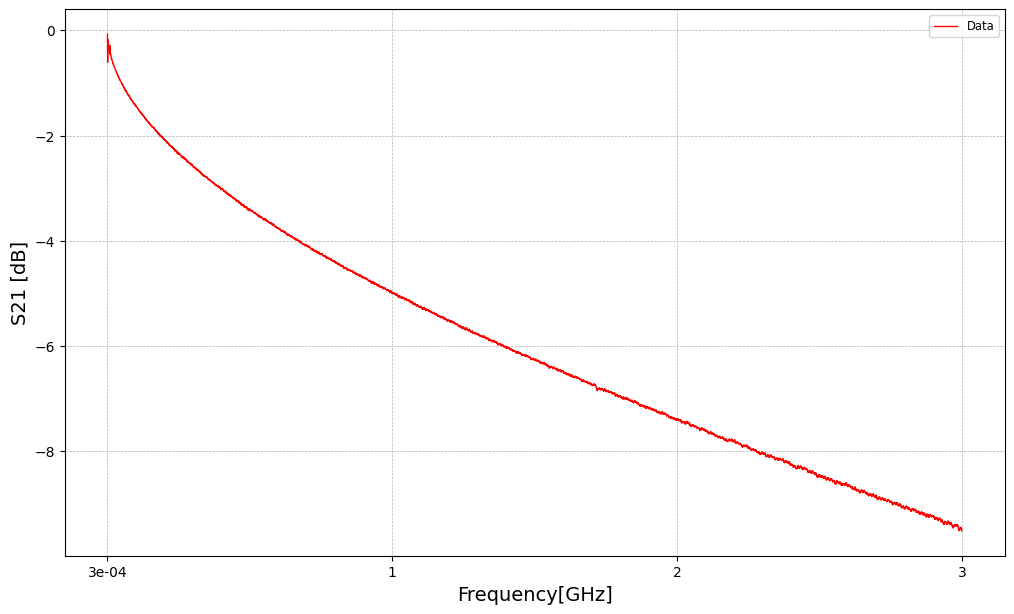

[-5.76277489  0.72772773]
[0.00283993 0.00347809]
['(-5.7628 ± 2.8 × 10^(-3)) × 10^0', '(7.277 ± 3.5 × 10^(-2)) × 10^-1']


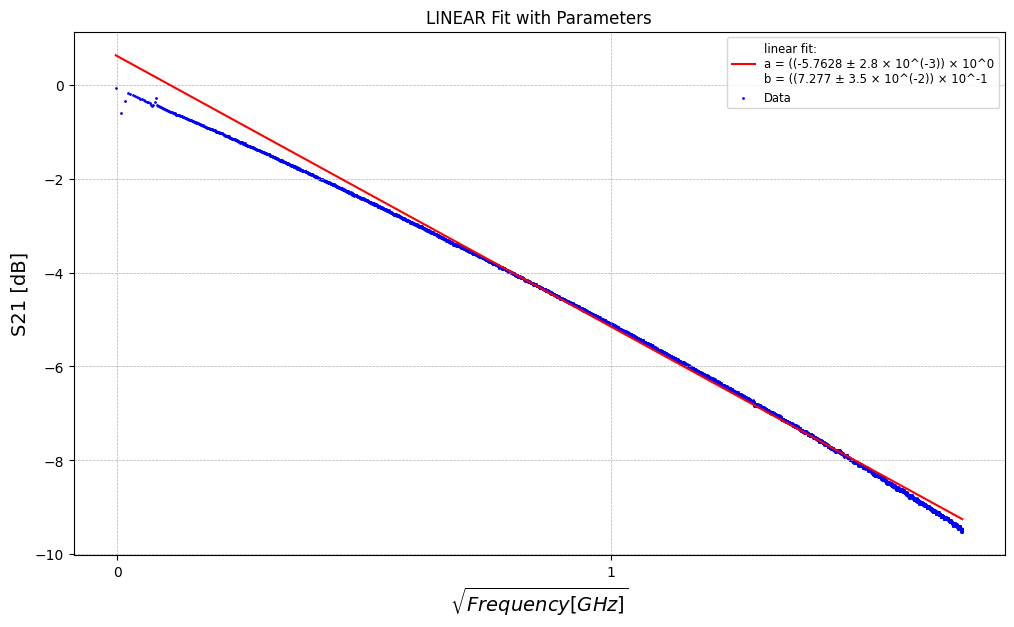

In [ ]:
AmpCable = mat_to_py(filename_AmpCable, labels = ["Frequency[GHz]", "S21 [dB]"])
AmpCable.plot(square_root = False, fit = False, fitlength=0.2, save = False)
AmpCable.plot(square_root = True, fit = True, fitlength=0.4, save = True)

In [ ]:
np.array([-5.7628, 2.8e-4])*(1/(8.686*np.sqrt(2*np.pi)*9.24))

array([-2.86451972e-02,  1.39179830e-06])

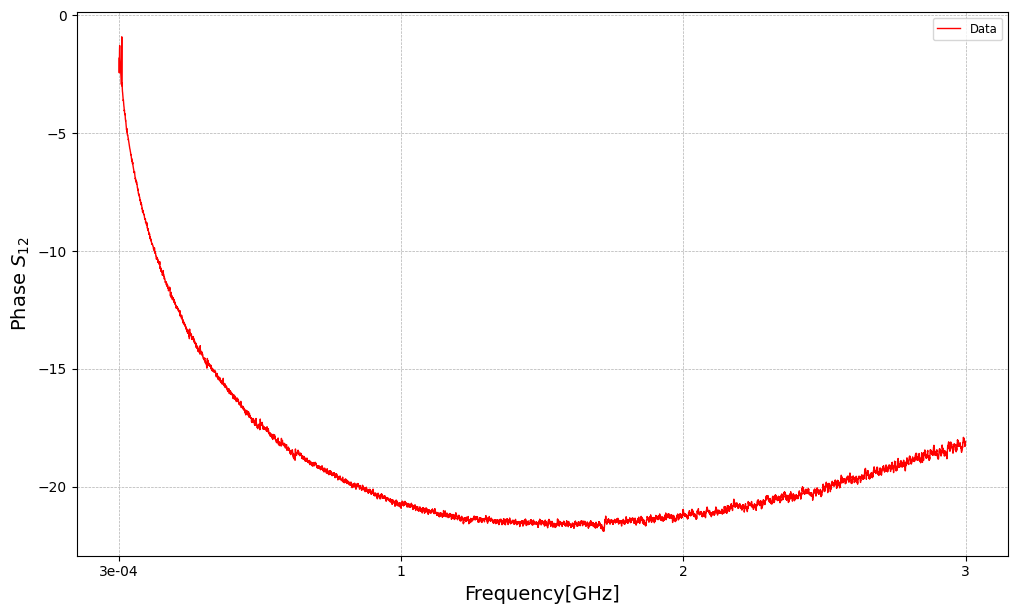

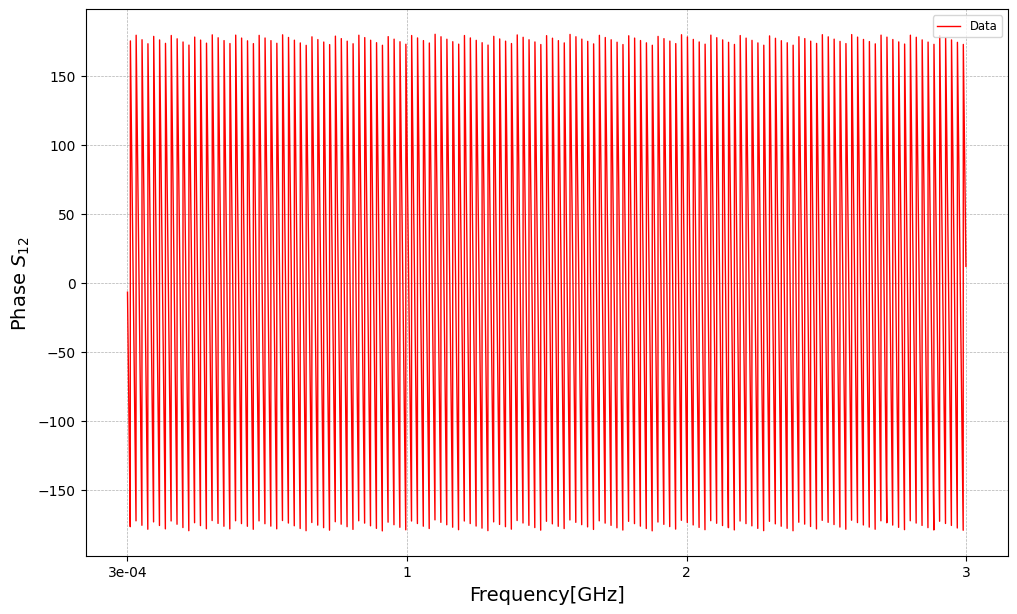

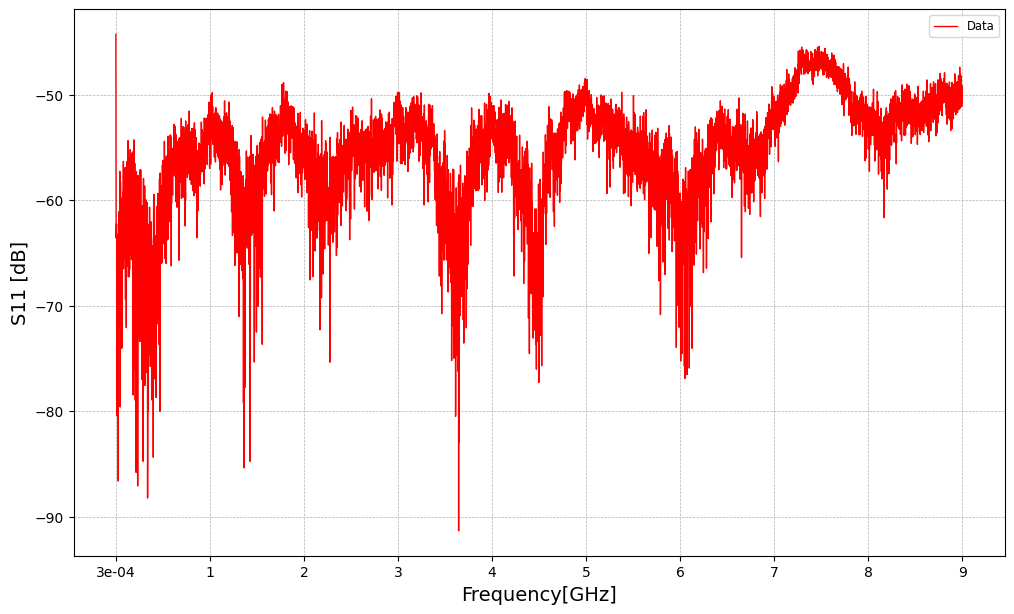

In [ ]:
CablePhase = mat_to_py(filename_CablePhase, labels = ["Frequency[GHz]","Phase $S_{12}$"])
CablePhase.plot(square_root = False, fit = False, fitlength=0.3)
CablePhaseNoDelay = mat_to_py(filename_CablePhaseNoDelay, labels = ["Frequency[GHz]","Phase $S_{12}$"])
CablePhaseNoDelay.plot(square_root = False, fit = False, fitlength=0.3)
MatchedLoadS11 = mat_to_py(filename_MatchedLoadS11, labels = ["Frequency[GHz]","S11 [dB]"])
MatchedLoadS11.plot(square_root = False, fit = False, fitlength=0.3)

In [ ]:
%cd /content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab02/PORT1

/content/drive/.shortcut-targets-by-id/1AuQag8Q8nLh3HEHq5FZHSemd0TKrzs7s/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab02/PORT1


In [ ]:
filename_GroupOpenCable = 'GroupDelayOpenCable.fig'
filename_OpenCablePhaseDelay = 'OpenCablePhaseDelay.fig'
filename_OpenCableReflexionAmplitude = 'OpenCableReflexionAmplitude.fig'
filename_OpenCableUntangledPhaseNoFit = 'OpenCableUntangledPhaseNoFit.fig'

[-1.44658460e-19  9.55011197e-08]
[1.21375657e-20 1.89486388e-11]
['(-1.45 ± 1.2 × 10^(-1)) × 10^-19', '(9.5501 ± 1.9 × 10^(-3)) × 10^-8']


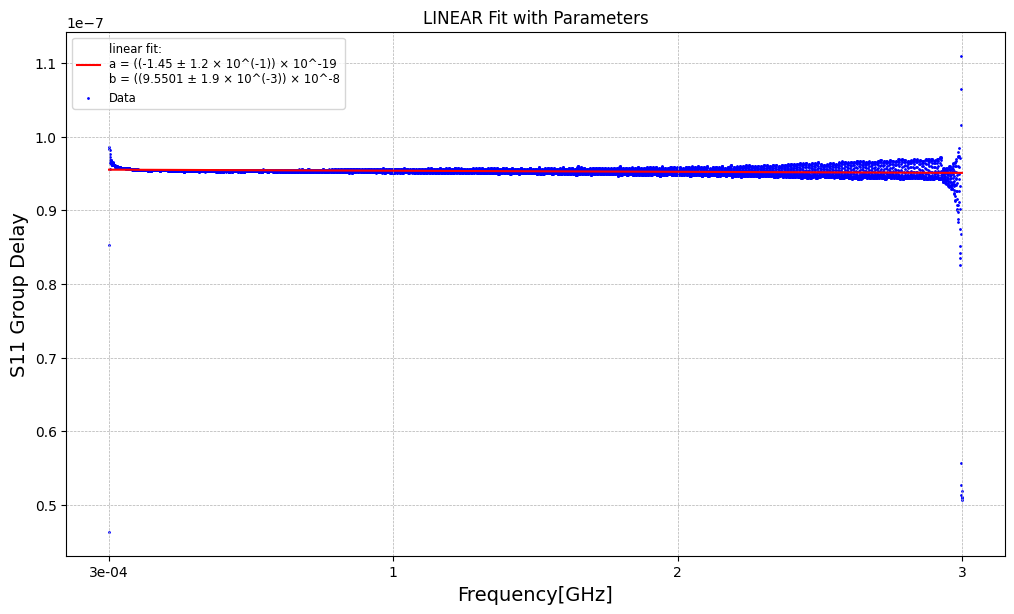

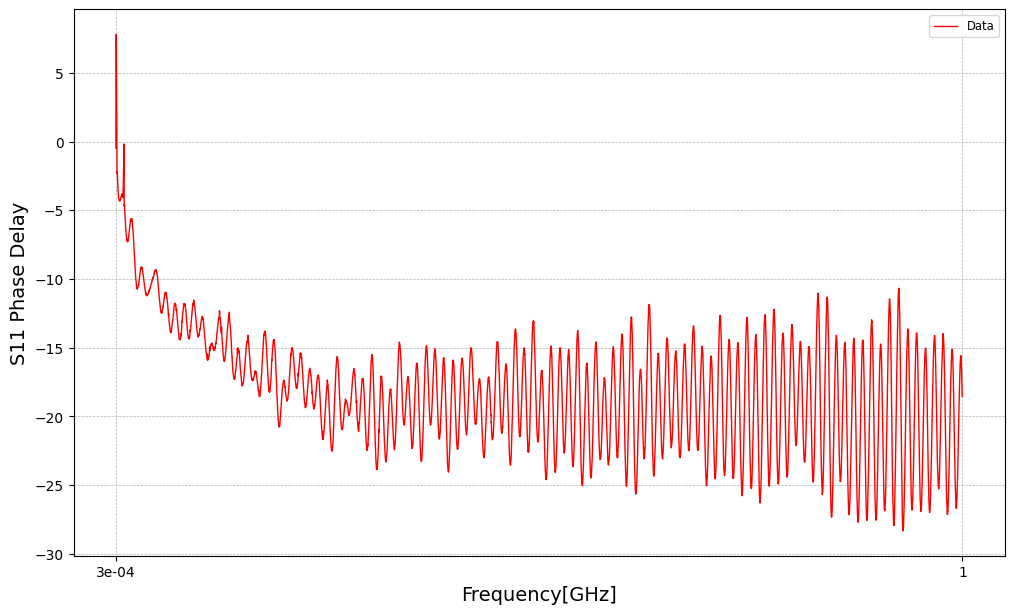

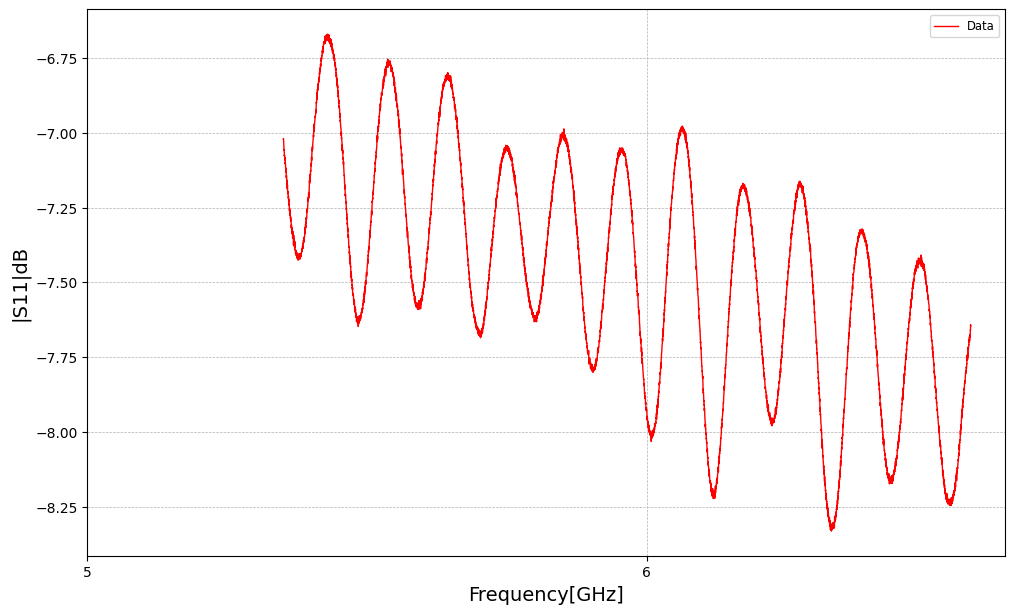

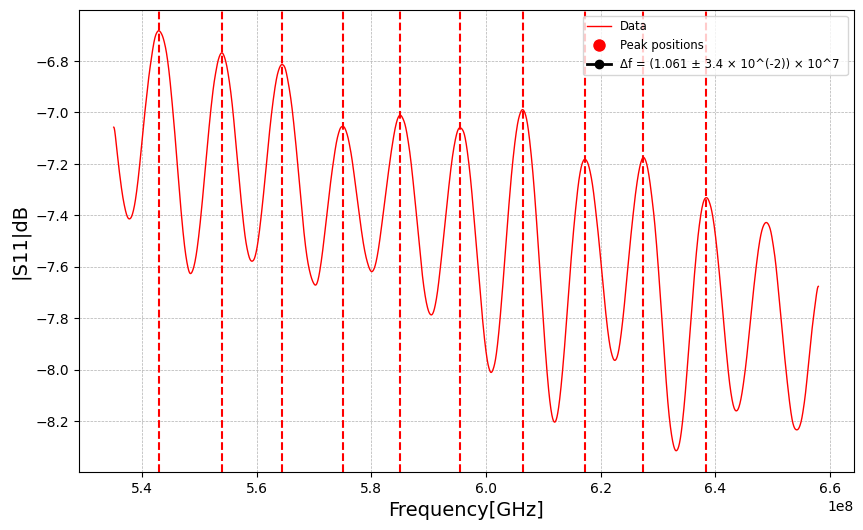

Mean distance between peaks: 10608547.52
std of distance between peaks: 335290.82
[-3.43022393e-05 -4.09748635e+01]
[4.20214023e-10 6.56018686e-01]
['(-3.430224 ± 4.2 × 10^(-5)) × 10^-5', '(-4.097 ± 6.6 × 10^(-2)) × 10^1']


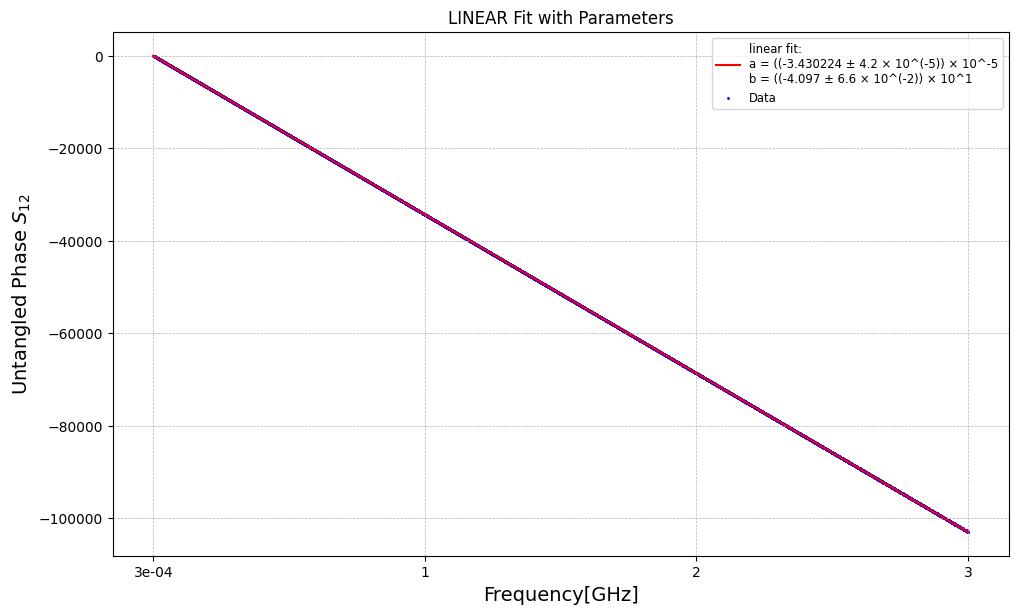

In [ ]:
GroupOpenCable = mat_to_py(filename_GroupOpenCable, labels = ["Frequency[GHz]", "S11 Group Delay"])
GroupOpenCable.plot(fit = True, fitlength=0.25, save = True)
OpenCablePhaseDelay = mat_to_py(filename_OpenCablePhaseDelay, labels = ["Frequency[GHz]", "S11 Phase Delay"])
OpenCablePhaseDelay.plot(fit = False, fitlength=0.25, save = True)
OpenCableReflexionAmplitude = mat_to_py(filename_OpenCableReflexionAmplitude, labels = ["Frequency[GHz]", "|S11|dB"])
OpenCableReflexionAmplitude.plot(fit = False, fitlength=0.25, save = True)
OpenCableReflexionAmplitude.peak_behaviour(num_peaks = 10, sigma_filter=10, save = True)
OpenCableUntangledPhaseNoFit = mat_to_py(filename_OpenCableUntangledPhaseNoFit, labels = ["Frequency[GHz]", "Untangled Phase $S_{12}$"])
OpenCableUntangledPhaseNoFit.plot(fit = True, fitlength=0.25, save = True)

In [ ]:
%cd /content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab02/PORT2
!ls


/content/drive/.shortcut-targets-by-id/1AuQag8Q8nLh3HEHq5FZHSemd0TKrzs7s/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab02/PORT2
GroupDelayOpenCable.fig		   OpenCablePhaseDelay.pdf
GroupDelayOpenCable_fit.pdf	   OpenCableUntangledPhaseFit.fig
OpenCableAmplitudeNoFit.fig	   UntangledPhaseNoDelay.fig
OpenCableAmplitudeNoFit.pdf	   UntangledPhaseNoDelayFit.fig
OpenCableAmplitudeNoFit_Peaks.pdf  UntangledPhaseNoDelay_fit.pdf
OpenCablePhaseDelay.fig


In [ ]:
filename_GroupOpenCable = 'GroupDelayOpenCable.fig'
filename_OpenCablePhaseDelay = 'OpenCablePhaseDelay.fig'
filename_OpenCableAmplitude = 'OpenCableAmplitudeNoFit.fig'
filename_UntangledPhaseNoDelay = 'UntangledPhaseNoDelay.fig'


[-9.93229265e-20  9.53874732e-08]
[6.23747640e-20 3.24644163e-11]
['(-9.9 ± 6.2 × 10^(0)) × 10^-20', '(9.5387 ± 3.2 × 10^(-3)) × 10^-8']


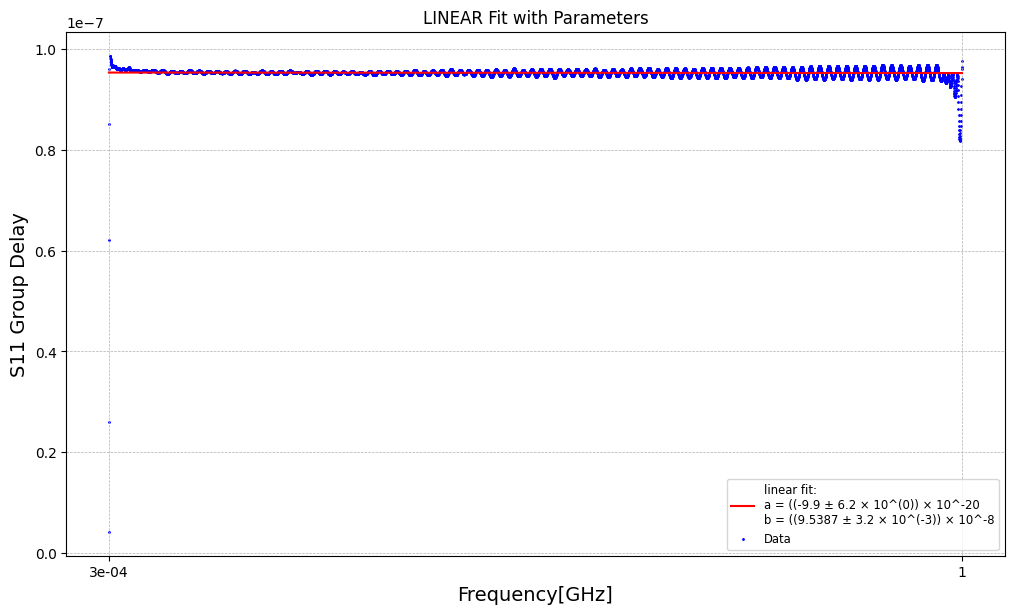

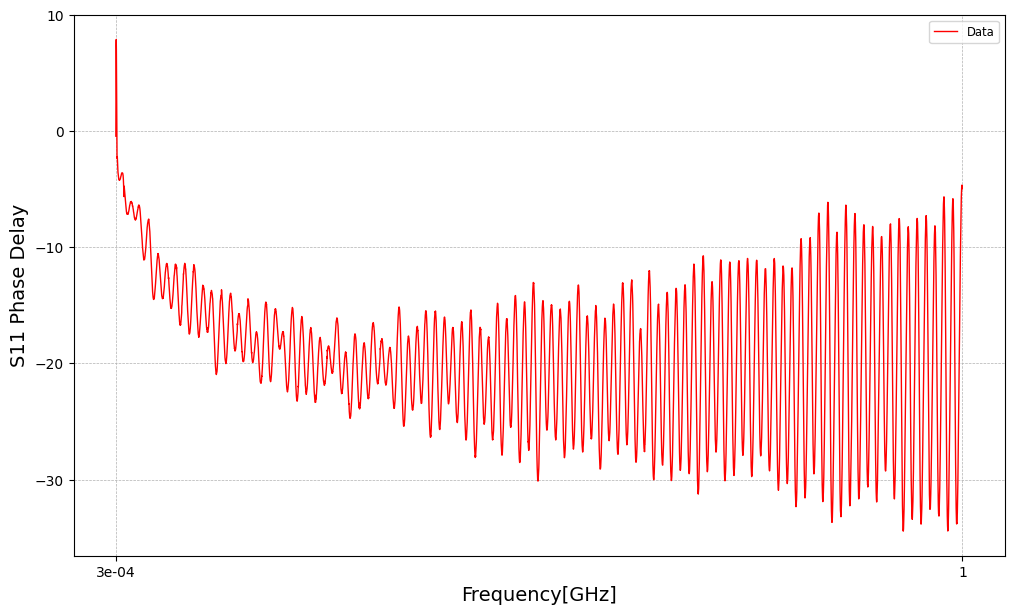

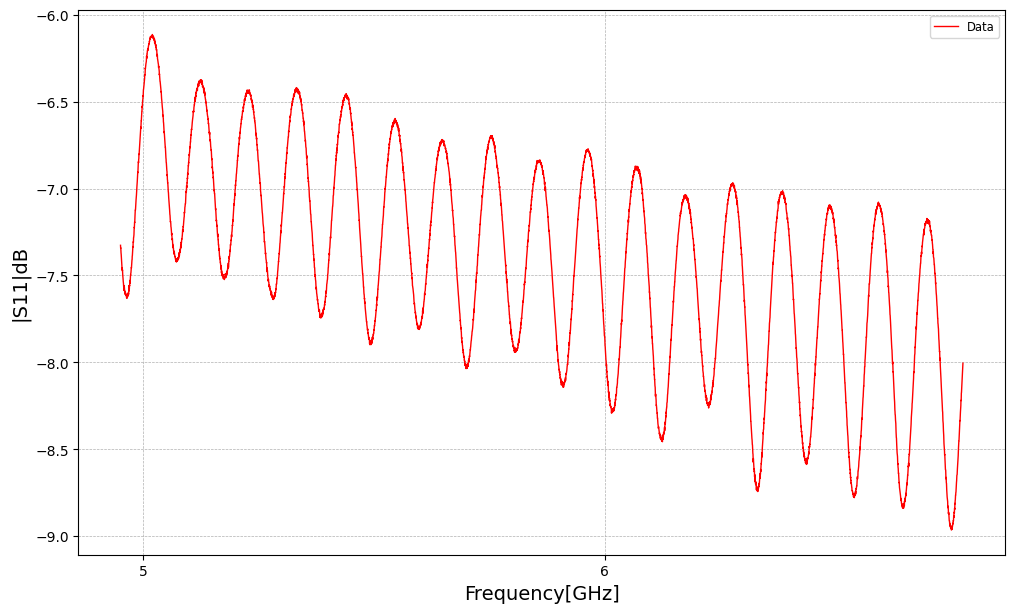

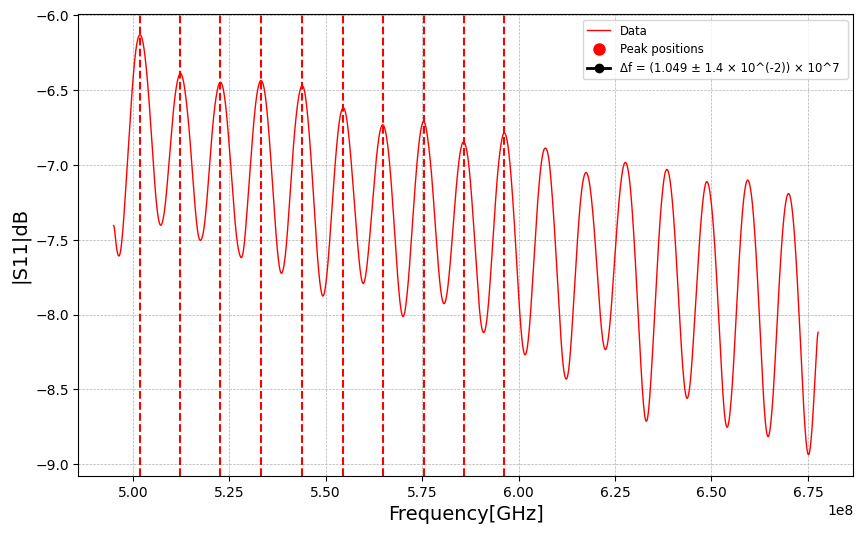

Mean distance between peaks: 10494891.55
std of distance between peaks: 144743.42
[-3.43215282e-05 -2.03816337e+01]
[5.54040573e-10 2.88363240e-01]
['(-3.432153 ± 5.5 × 10^(-5)) × 10^-5', '(-2.038 ± 2.9 × 10^(-2)) × 10^1']


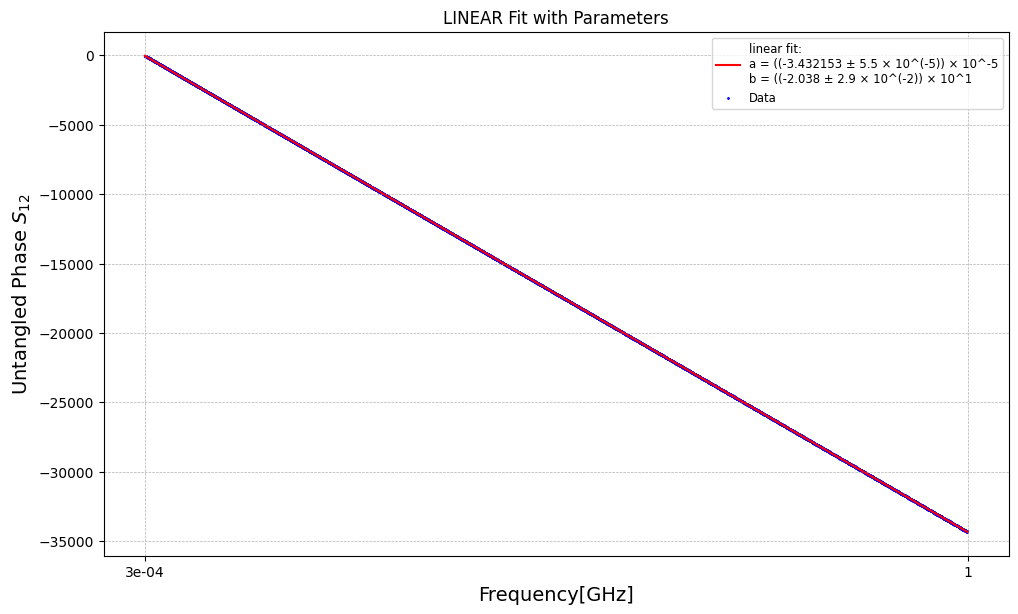

In [ ]:
GroupOpenCable = mat_to_py(filename_GroupOpenCable, labels = ["Frequency[GHz]", "S11 Group Delay"])
GroupOpenCable.plot(fit = True, fitlength=0.25, save = True)
OpenCablePhaseDelay = mat_to_py(filename_OpenCablePhaseDelay, labels = ["Frequency[GHz]", "S11 Phase Delay"])
OpenCablePhaseDelay.plot(fit = False, fitlength=0.25, save = True)
OpenCableAmplitude = mat_to_py(filename_OpenCableAmplitude, labels = ["Frequency[GHz]", "|S11|dB"])
OpenCableAmplitude.plot(fit = False, fitlength=0.25, save = True)
OpenCableAmplitude.peak_behaviour(num_peaks = 10, sigma_filter=10, save = True)
UntangledPhaseNoDelay = mat_to_py(filename_UntangledPhaseNoDelay, labels = ["Frequency[GHz]", "Untangled Phase $S_{12}$"])
UntangledPhaseNoDelay.plot(fit = True, fitlength=0.25, save = True)

In [ ]:
%cd /content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab02/ATENUATOR
!ls
filename_S11dB = 'S11dB.fig'
filename_S12dB = 'S12dB.fig'
filename_S12PhaseGROUPDELAY = 'S12PhaseGROUPDELAY_NoFit.fig'
filename_S12PhaseUNWRAPPED = 'S12PhaseUNWRAPPED_NoFit.fig'
filename_S21dB = 'S21dB.fig'
filename_S22dB = 'S22.fig'
S11dB = mat_to_py(filename_S11dB, labels = ["Frequency[GHz]", "S11 [dB]"])
S12dB = mat_to_py(filename_S12dB, labels = ["Frequency[GHz]", "S12 [dB]"])
S21dB = mat_to_py(filename_S21dB, labels = ["Frequency[GHz]", "S21 [dB]"])
S22dB = mat_to_py(filename_S22dB, labels = ["Frequency[GHz]", "S22 [dB]"])
S12_GroupDelay = mat_to_py(filename_S12PhaseGROUPDELAY, labels = ["Frequency[GHz]", "S12 Group Delay [s]"])
S12_Phase = mat_to_py(filename_S12PhaseUNWRAPPED, labels = ["Frequency[GHz]", "S12 Phase [deg]"])

/content/drive/.shortcut-targets-by-id/1AuQag8Q8nLh3HEHq5FZHSemd0TKrzs7s/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab02/ATENUATOR
S11dB.fig		    S12PhaseGROUPDELAY_NoFit.fig      S21dB.fig
S11dB.pdf		    S12PhaseGROUPDELAY_NoFit_fit.pdf  S21dB.pdf
S12dB.fig		    S12PhaseUNWRAPPED_Fit.fig	      S22.fig
S12dB.pdf		    S12PhaseUNWRAPPED_fit.pdf	      S22.pdf
S12PhaseGROUPDELAY_Fit.fig  S12PhaseUNWRAPPED_NoFit.fig
S12PhaseGROUPDELAY_fit.pdf  S12PhaseUNWRAPPED_NoFit_fit.pdf


In [ ]:
savestatus = True

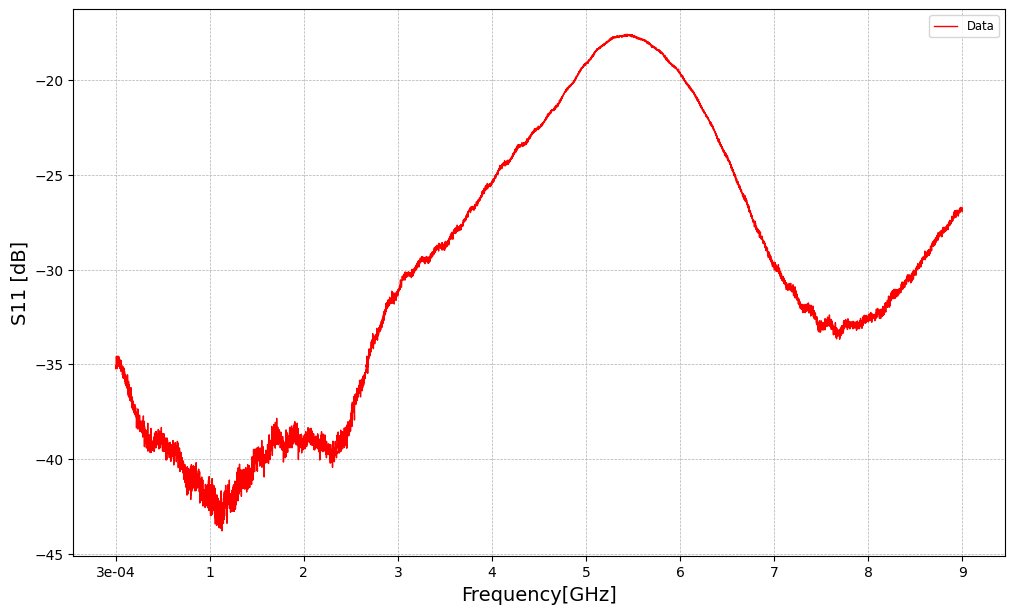

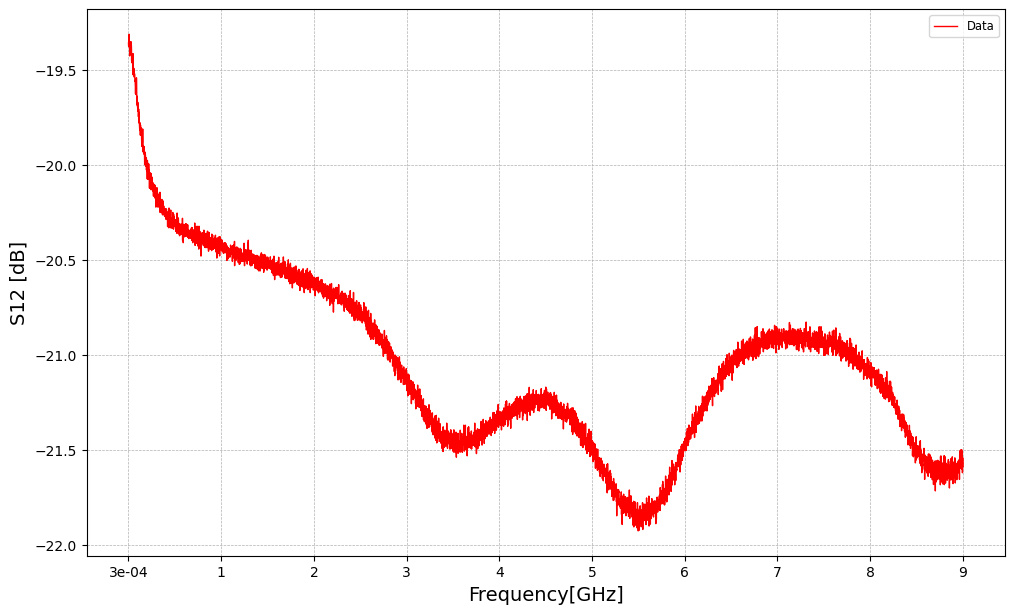

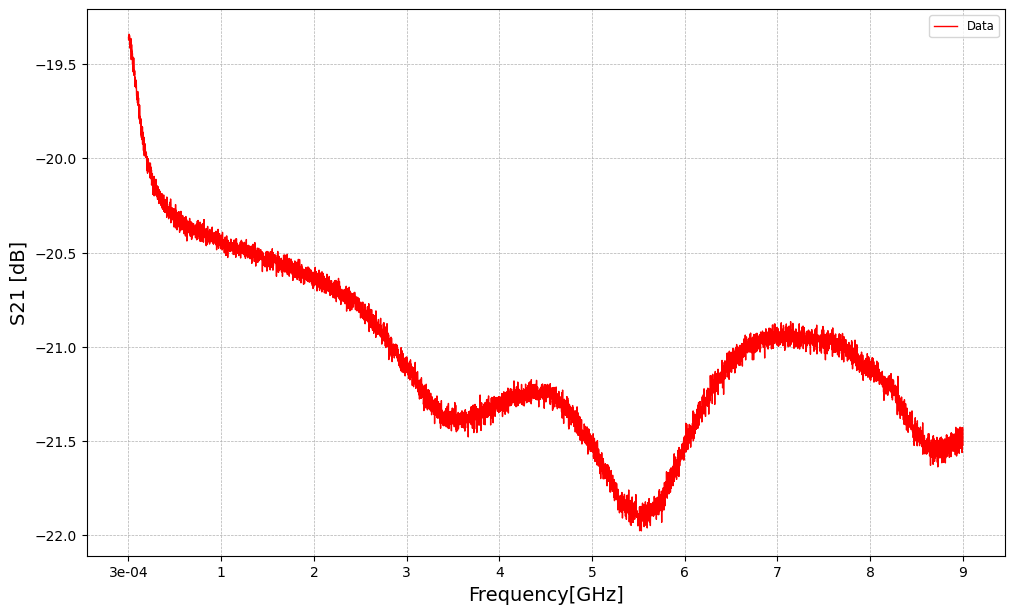

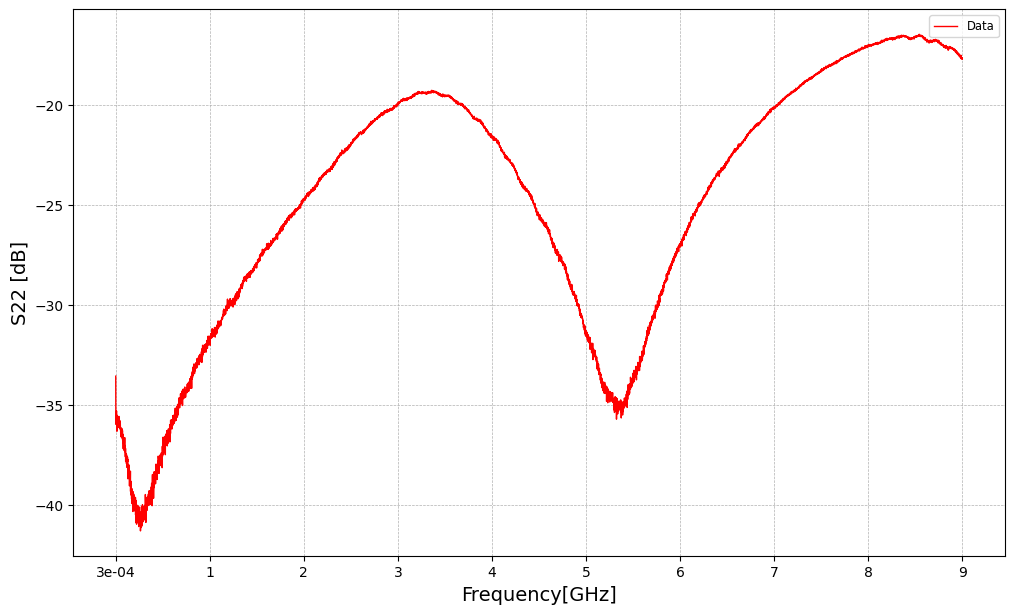

In [ ]:
S11dB.plot(square_root = False, save = savestatus)
S12dB.plot(square_root = False, save = savestatus)
S21dB.plot(square_root = False, save = savestatus)
S22dB.plot(square_root = False, save = savestatus)

[4.50015    4.5015562  4.50296241 ... 6.29587139 6.29727759 6.2986838 ]
[0.2063764  0.13855121 0.1230487  ... 0.1412456  0.14415924 0.0883124 ]
[-6.71058237e-21  1.71813196e-10]
[3.21232355e-21 1.74248003e-11]
['(-6.7 ± 3.2 × 10^(0)) × 10^-21', '(1.72 ± 1.7 × 10^(-1)) × 10^-10']


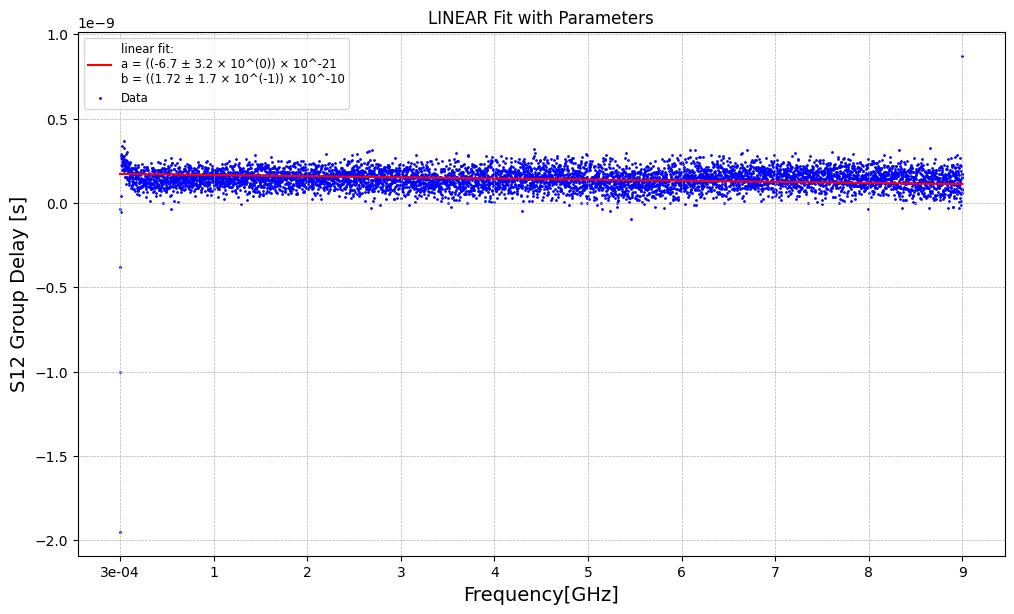

[4.50015    4.5015562  4.50296241 ... 6.29587139 6.29727759 6.2986838 ]
[-2.36434265 -2.35956787 -2.36972626 ... -3.23777069 -3.24032898
 -3.24243134]
[-4.72349573e-08 -2.58504090e+01]
[4.66330293e-11 2.52954351e-01]
['(-4.7235 ± 4.7 × 10^(-3)) × 10^-8', '(-2.585 ± 2.5 × 10^(-2)) × 10^1']


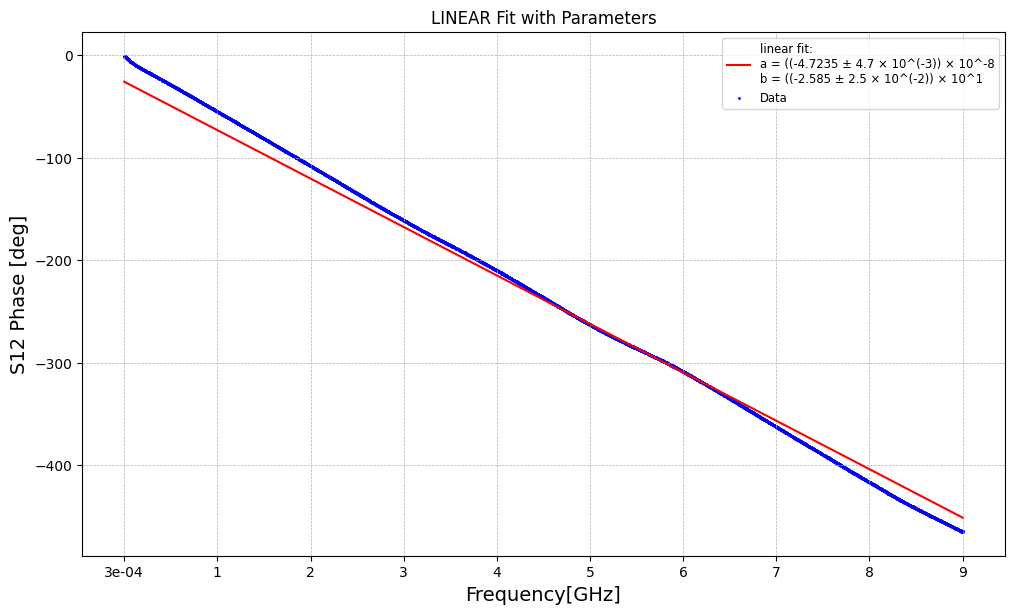

In [ ]:
S12_GroupDelay.plot(fit = True)
S12_Phase.plot(square_root = False, save = True, fit = True)

/content/drive/.shortcut-targets-by-id/1AuQag8Q8nLh3HEHq5FZHSemd0TKrzs7s/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab02
ATENUATOR	     UntangledPhaseNoDelay.fig
GroupDelayCable.fig  UntangledPhaseNoDelayFit.fig
PORT1		     UntangledPhaseNoDelay_fit.pdf
PORT2
[-1.71494303e-05 -2.03808003e+01]
[1.89345753e-11 2.95597354e-02]
['(-1.7149430 ± 1.9 × 10^(-6)) × 10^-5', '(-2.0381 ± 3.0 × 10^(-3)) × 10^1']


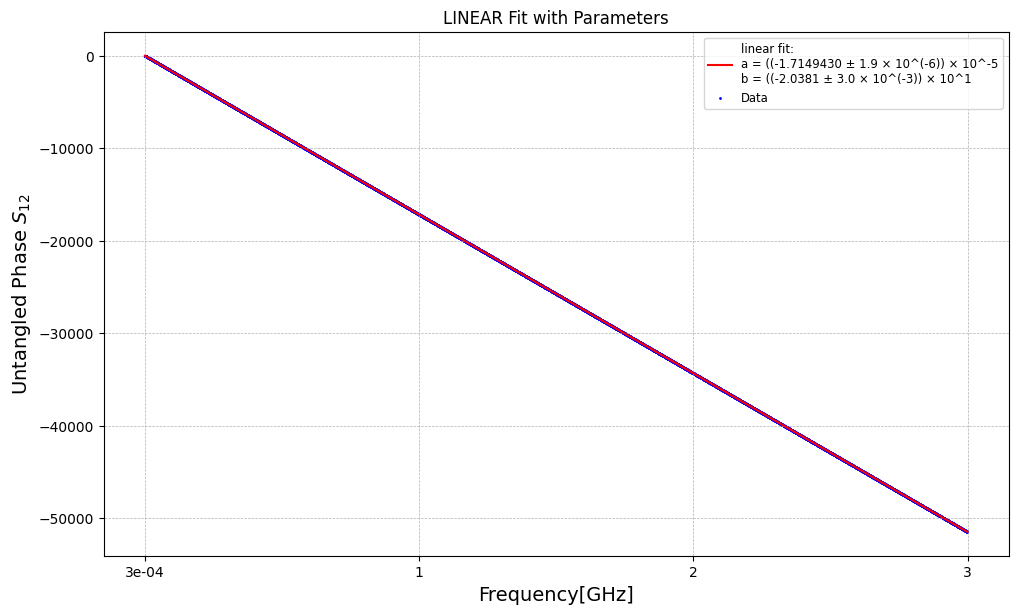

In [ ]:
%cd /content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab02
!ls
UntangledPhaseNoDelay = 'UntangledPhaseNoDelay.fig'
UntangledPhaseNoDelay = mat_to_py(UntangledPhaseNoDelay, labels = ["Frequency[GHz]", "Untangled Phase $S_{12}$"])
UntangledPhaseNoDelay.plot(fit = True, fitlength=0.25, save = True)

In [ ]:
%cd /content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab03/BPM
!ls

/content/drive/.shortcut-targets-by-id/1AuQag8Q8nLh3HEHq5FZHSemd0TKrzs7s/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab03/BPM
S11dB.fig		       S22SmithChart.fig
S11dB.pdf		       S22UntangledPhase_FIT.fig
S11GroupDelay_FIT.fig	       S22UntangledPhase_FIT_fit.pdf
S11GroupDelay_FIT_fit.pdf      S23dB_FullFreqRange.fig
S11_peak_dB.pdf		       S23dB_FullFreqRange.pdf
S11SmithChart.fig	       S24dB_FullFreqRange.fig
S11UntangledPhase.fig	       S24dB_FullFreqRange.pdf
S11UntangledPhase_FIT.fig      S33dB.fig
S11UntangledPhase_FIT_fit.pdf  S33dB.pdf
S12dB_FullFreqRange.fig        S33SmithChart.fig
S12dB_FullFreqRange.pdf        S33UntangledPhase_FIT.fig
S13dB_FullFreqRange.fig        S33UntangledPhase_FIT_fit.pdf
S13dB_FullFreqRange.pdf        S34dB_FullFreqRange.fig
S14dB_FullFreqRange.fig        S34dB_FullFreqRange.pdf
S14dB_FullFreqRange.pdf        S44dB.fig
S22dB.fig		       S44dB.pdf
S22dB.pdf		       S44UntangledPhase_FIT.fig
S22GroupDelay_FIT.fig	       S44UntangledPhase_FIT_

In [ ]:
# PORT 1

S11dB_filename = 'S11dB.fig'
S11GroupDelay_filename = 'S11GroupDelay_FIT.fig'
S11UntangledPhase_filename = 'S11UntangledPhase_FIT.fig'

S12dB_filename = 'S12dB_FullFreqRange.fig'
S13dB_filename = 'S13dB_FullFreqRange.fig'
S14dB_filename = 'S14dB_FullFreqRange.fig'

# PORT 2

S22dB_filename = 'S22dB.fig'
S22GroupDelay_filename = 'S22GroupDelay_FIT.fig'
S22UntangledPhase_filename = 'S22UntangledPhase_FIT.fig'

S23dB_filename = 'S23dB_FullFreqRange.fig'
S24dB_filename = 'S24dB_FullFreqRange.fig'

# PORT 3

S33dB_filename = 'S33dB.fig'
S33UntangledPhase_filename = 'S33UntangledPhase_FIT.fig'

S34dB_filename = 'S34dB_FullFreqRange.fig'

# PORT 4

S44dB_filename = 'S44dB.fig'
S44UntangledPhase_filename = 'S44UntangledPhase_FIT.fig'


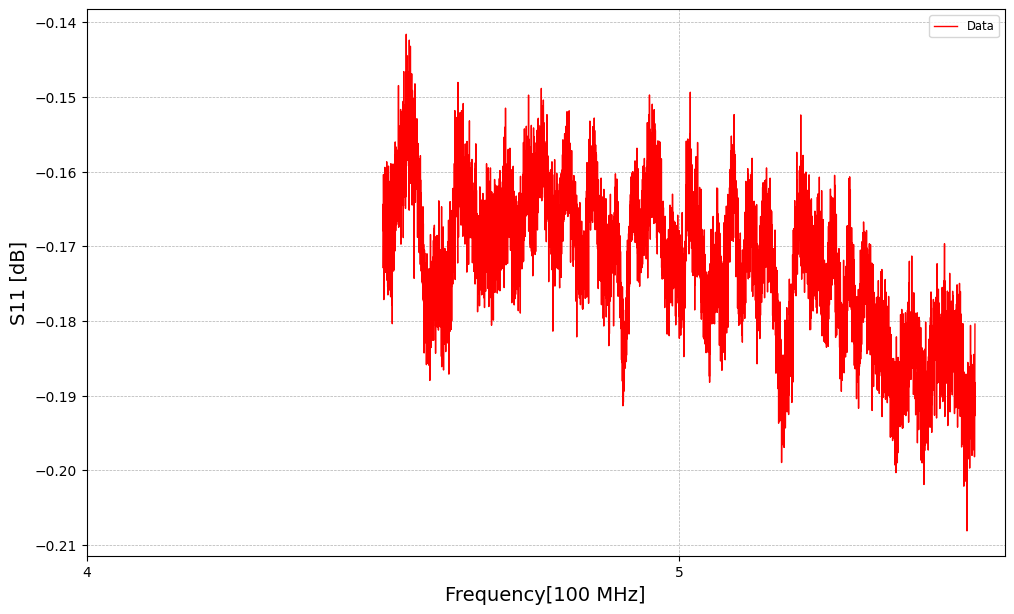

[7.86241178e-19 9.98835777e-10]
[2.68728774e-19 6.21103580e-11]
['(7.9 ± 2.7 × 10^(0)) × 10^-19', '(9.99 ± 6.2 × 10^(-1)) × 10^-10']


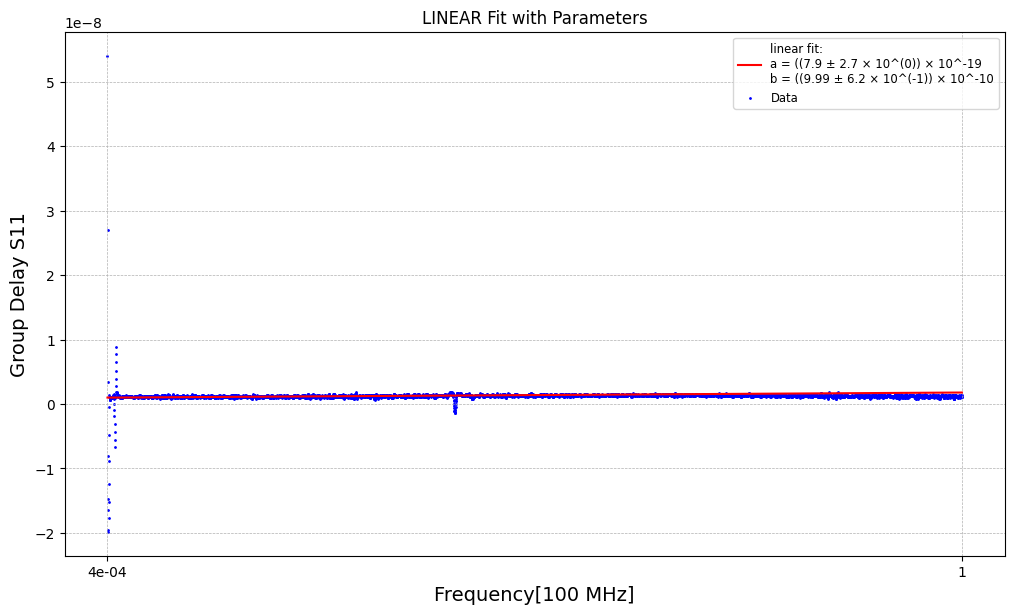

[-4.22972855e-07  1.80754765e+02]
[1.64680068e-10 3.80619380e-02]
['(-4.2297 ± 1.6 × 10^(-3)) × 10^-7', '(1.80755 ± 3.8 × 10^(-4)) × 10^2']


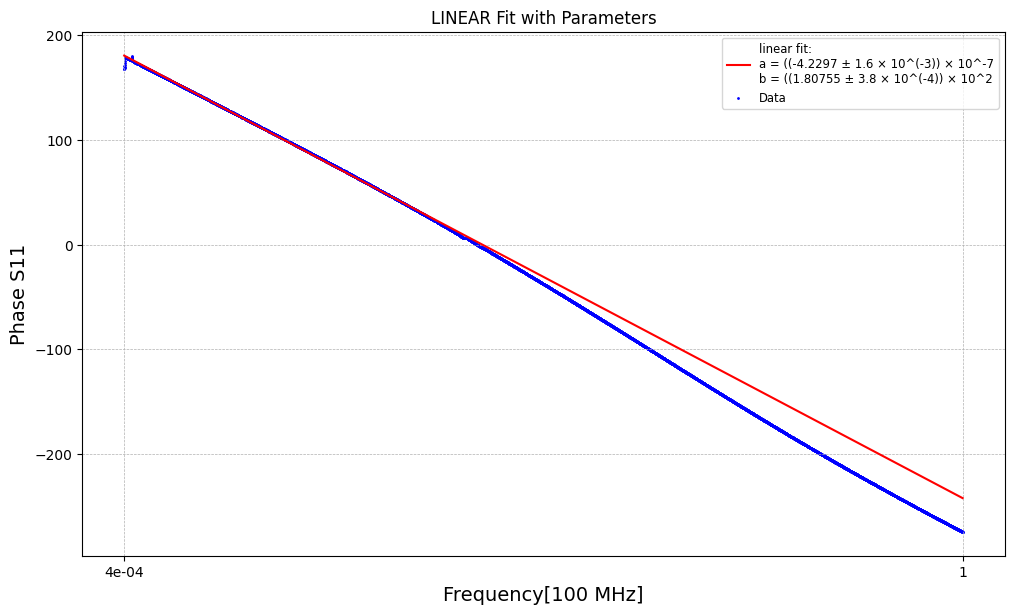

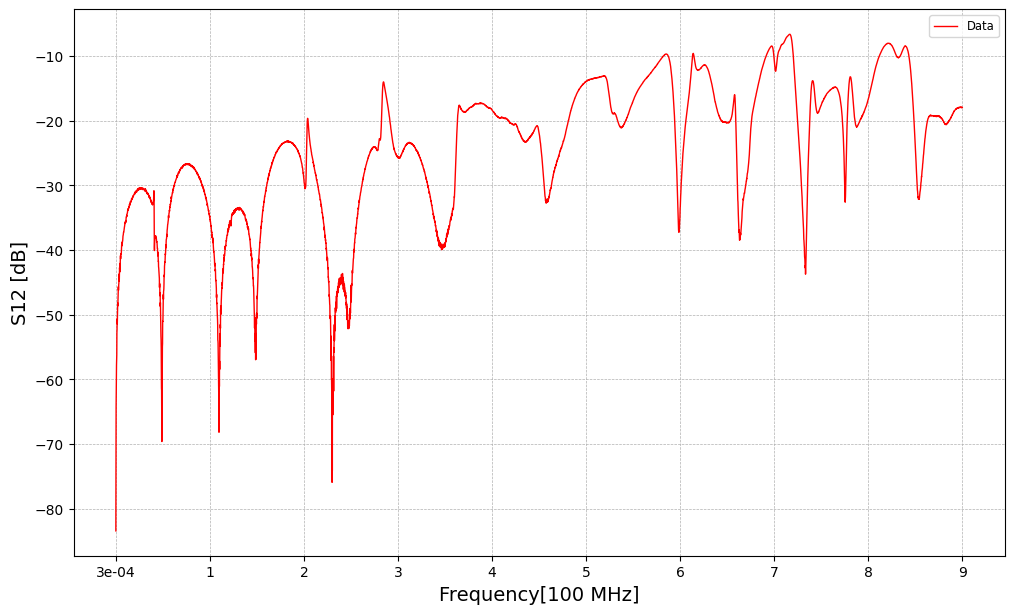

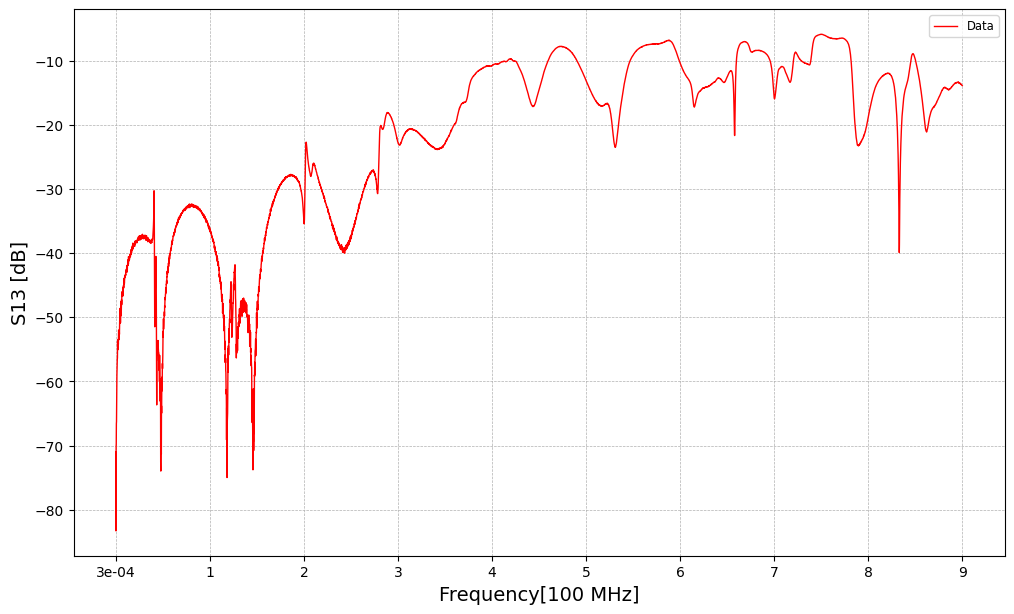

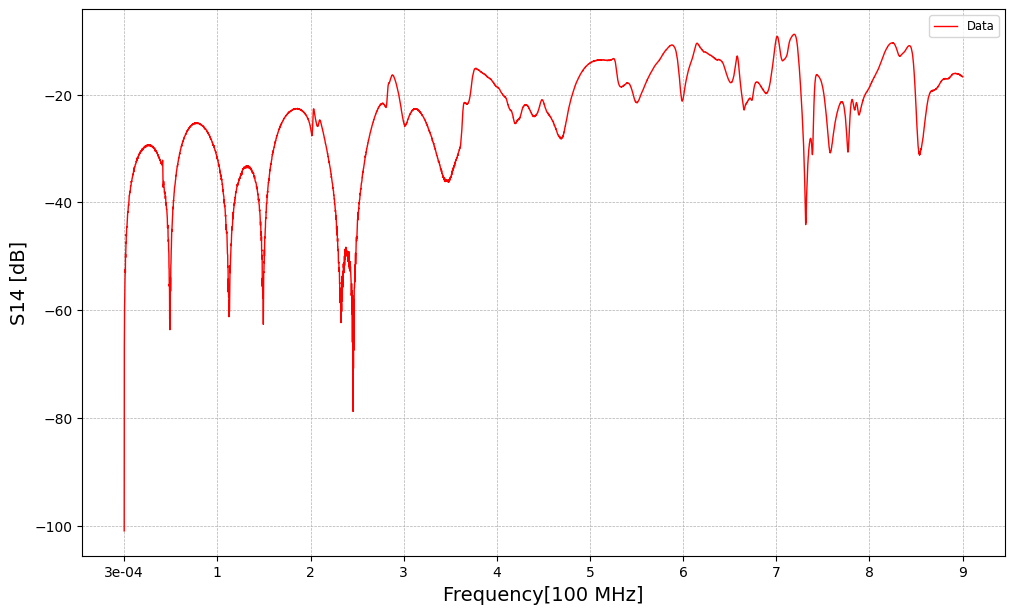

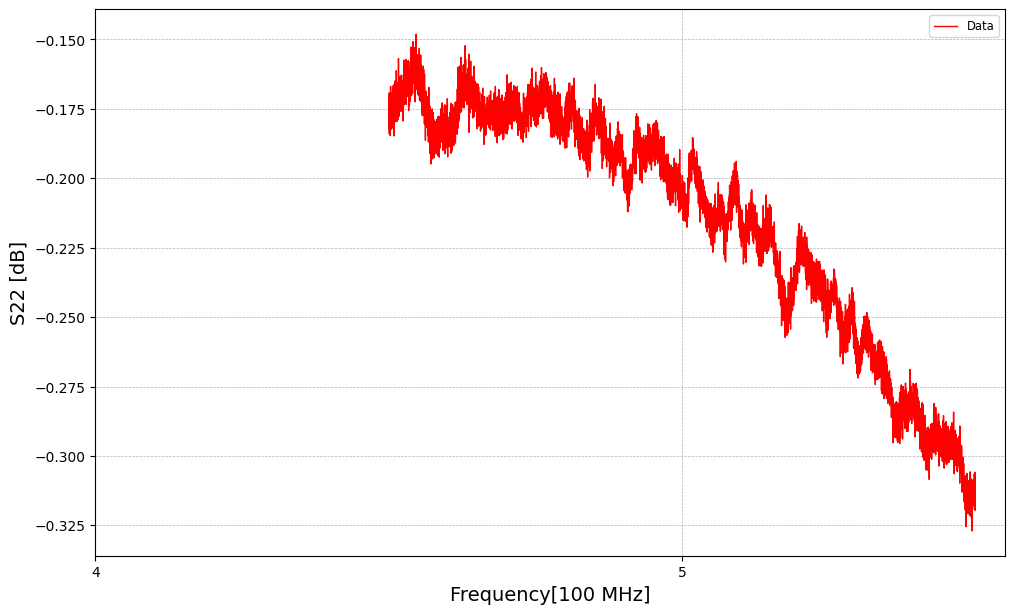

[1.52130142e-18 7.68845510e-10]
[2.46035178e-19 5.68652648e-11]
['(1.52 ± 2.5 × 10^(-1)) × 10^-18', '(7.69 ± 5.7 × 10^(-1)) × 10^-10']


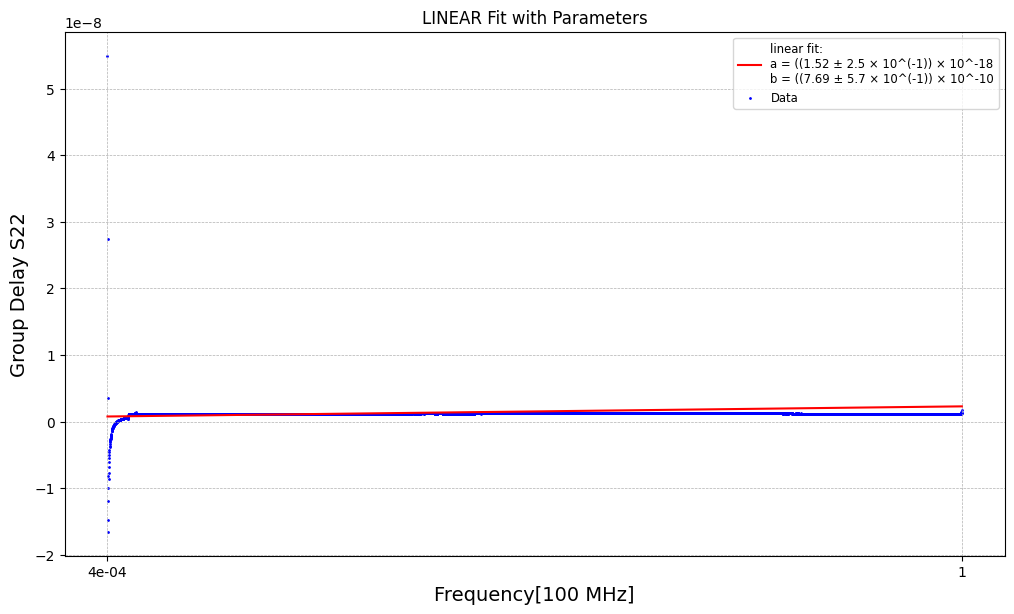

[-4.16418961e-07  1.80364028e+02]
[1.34548540e-10 3.10977418e-02]
['(-4.1642 ± 1.3 × 10^(-3)) × 10^-7', '(1.80364 ± 3.1 × 10^(-4)) × 10^2']


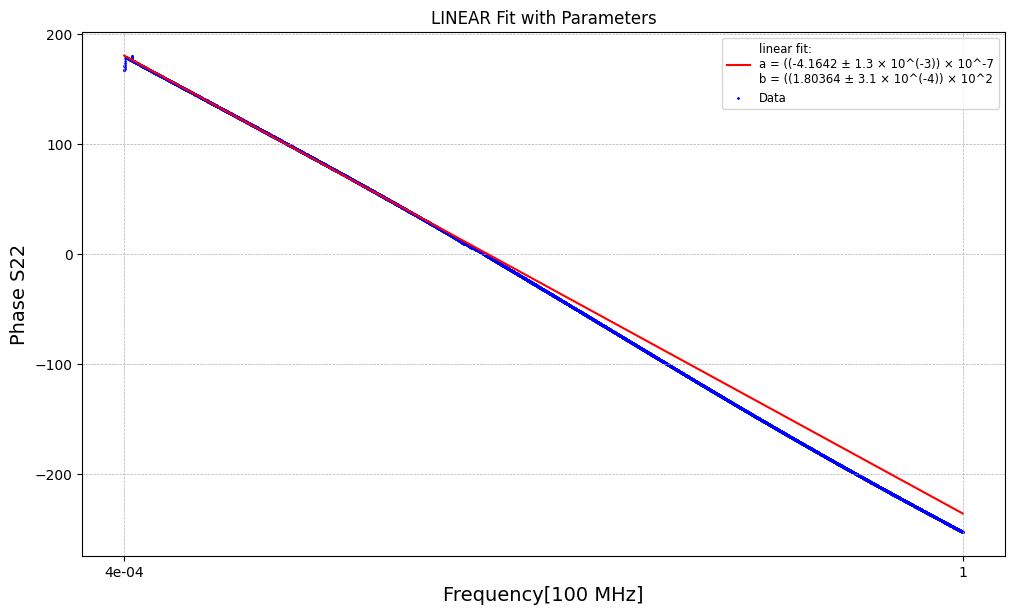

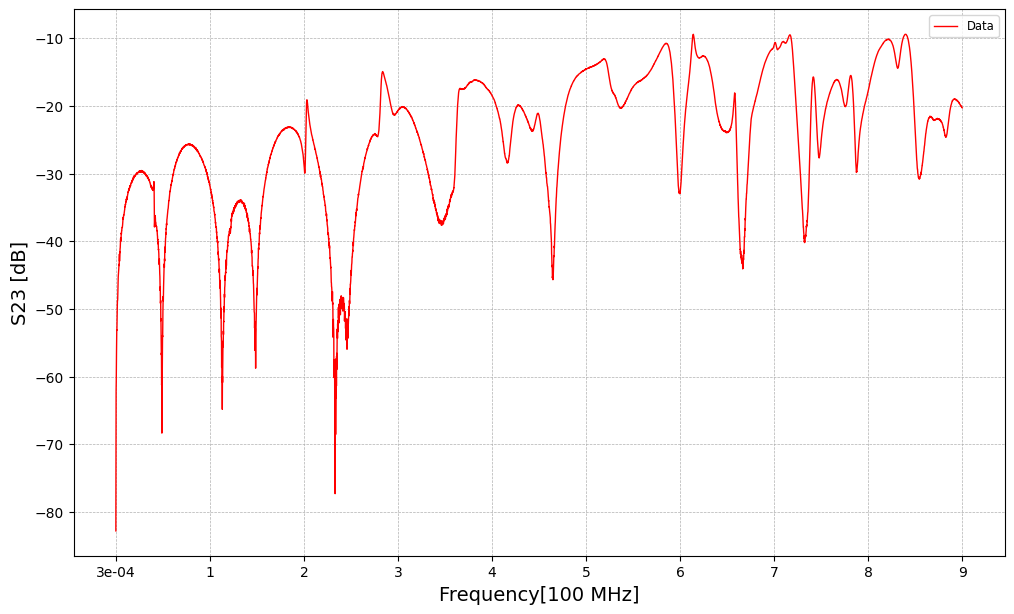

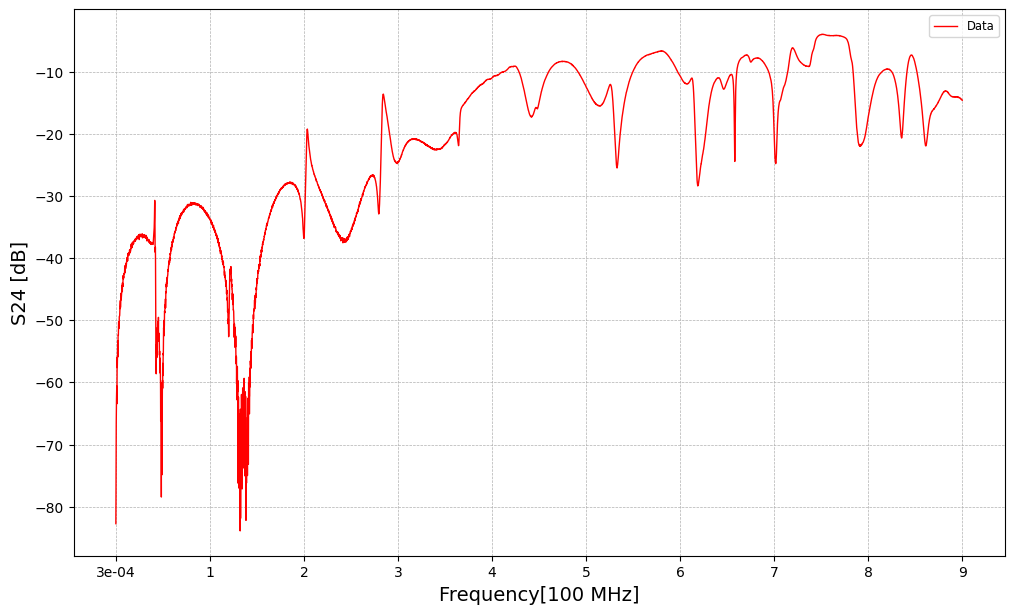

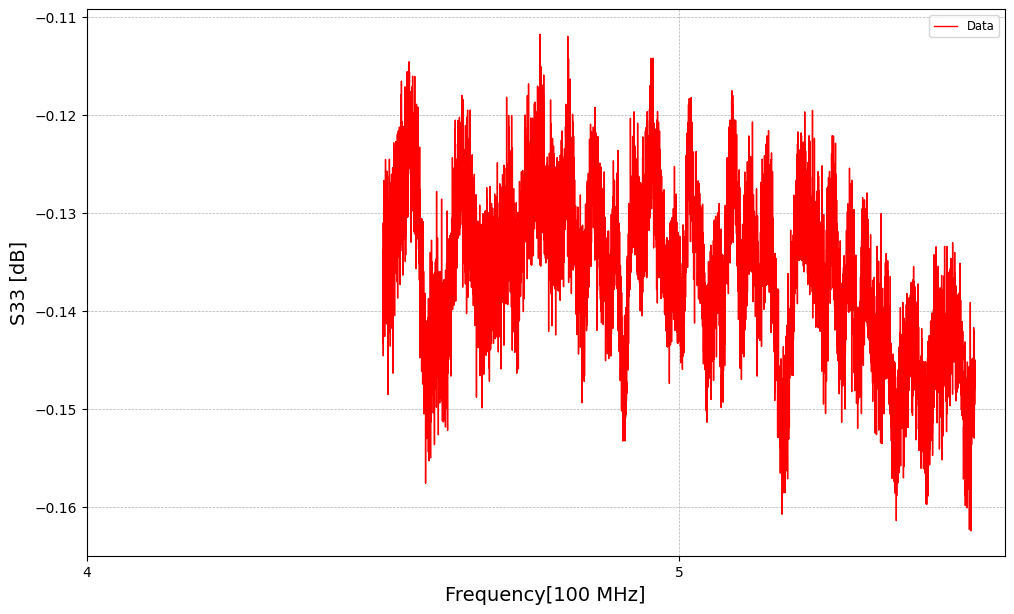

[-4.31080064e-07  1.79713561e+02]
[1.00087216e-10 2.31328140e-02]
['(-4.3108 ± 1.0 × 10^(-3)) × 10^-7', '(1.79714 ± 2.3 × 10^(-4)) × 10^2']


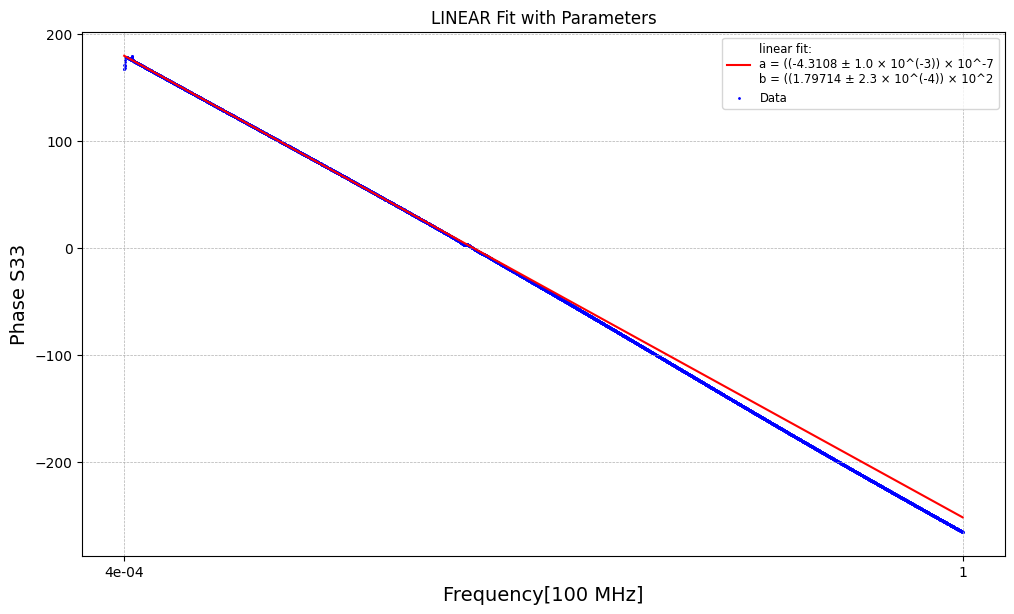

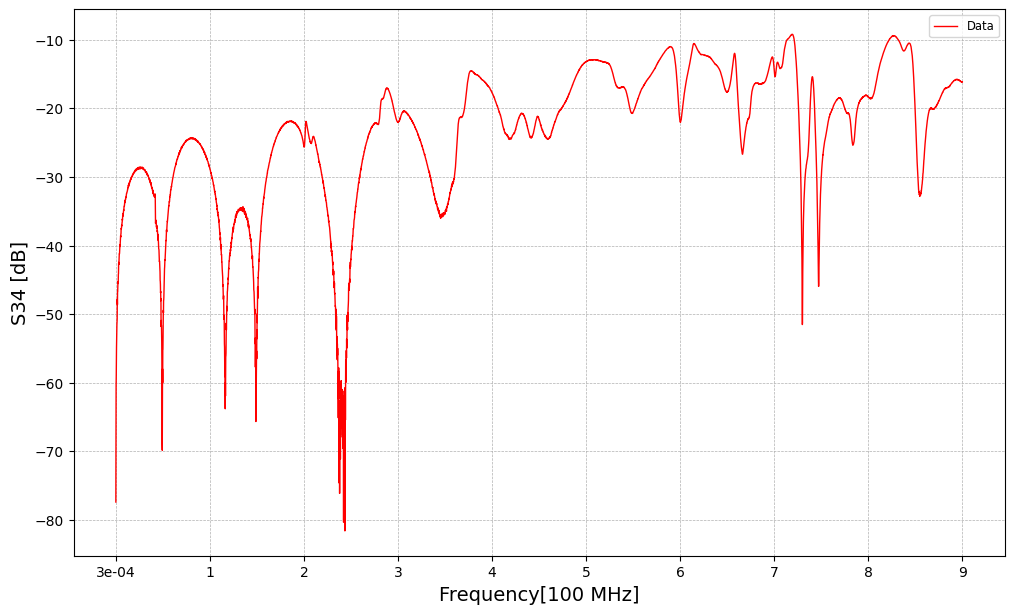

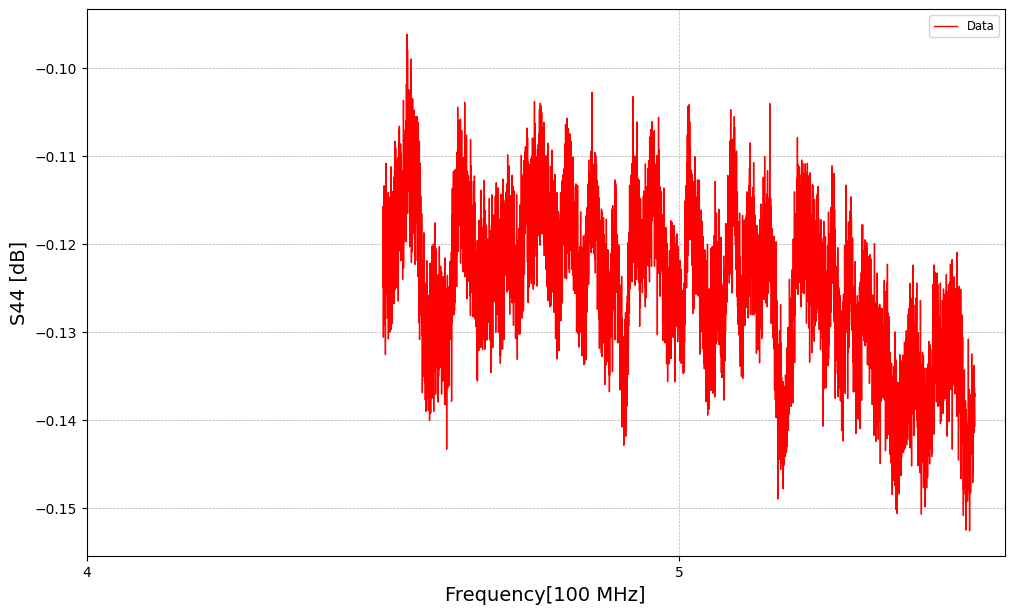

[-4.39689963e-07  1.78958151e+02]
[9.64946035e-11 2.23024661e-02]
['(-4.39690 ± 9.6 × 10^(-4)) × 10^-7', '(1.78958 ± 2.2 × 10^(-4)) × 10^2']


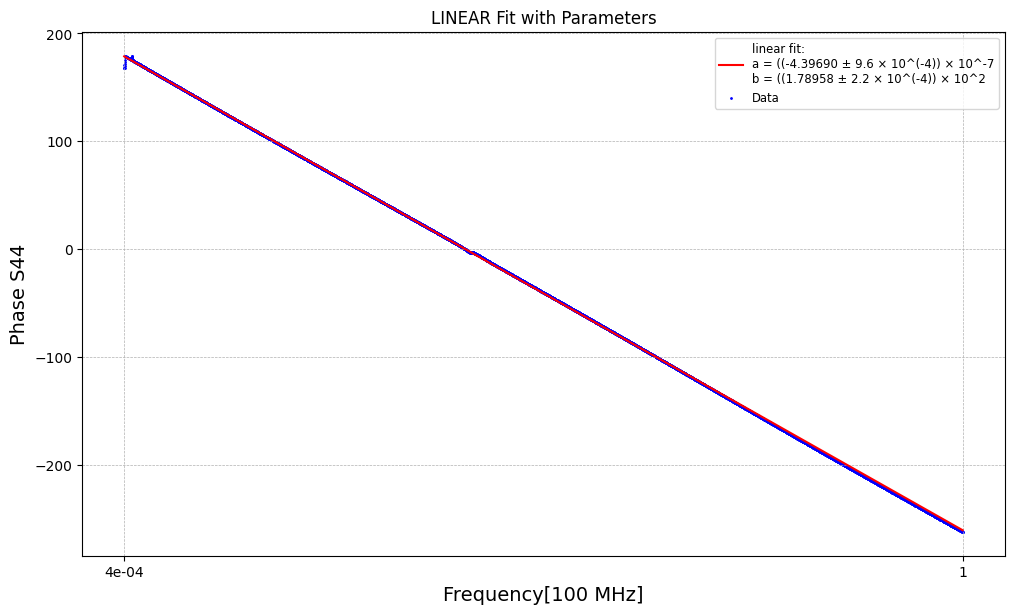

In [ ]:
savefile = True
plot_configs = [
    # (var_name, filename_var, label, plot_type)
    ("S11dB", S11dB_filename, "S11 [dB]", "dB"),
    ("S11GroupDelay", S11GroupDelay_filename, "Group Delay S11", "fit"),
    ("S11UntangledPhase", S11UntangledPhase_filename, "Phase S11", "fit"),
    ("S12dB", S12dB_filename, "S12 [dB]", "dB"),
    ("S13dB", S13dB_filename, "S13 [dB]", "dB"),
    ("S14dB", S14dB_filename, "S14 [dB]", "dB"),

    ("S22dB", S22dB_filename, "S22 [dB]", "dB"),
    ("S22GroupDelay", S22GroupDelay_filename, "Group Delay S22", "fit"),
    ("S22UntangledPhase", S22UntangledPhase_filename, "Phase S22", "fit"),
    ("S23dB", S23dB_filename, "S23 [dB]", "dB"),
    ("S24dB", S24dB_filename, "S24 [dB]", "dB"),

    ("S33dB", S33dB_filename, "S33 [dB]", "dB"),
    ("S33UntangledPhase", S33UntangledPhase_filename, "Phase S33", "fit"),
    ("S34dB", S34dB_filename, "S34 [dB]", "dB"),

    ("S44dB", S44dB_filename, "S44 [dB]", "dB"),
    ("S44UntangledPhase", S44UntangledPhase_filename, "Phase S44", "fit"),
]

for var_name, filename, ylabel, plot_type in plot_configs:
    globals()[var_name] = mat_to_py(filename, labels=["Frequency[100 MHz]", ylabel])

    if plot_type == "dB":
        globals()[var_name].plot(square_root=False, fit=False, save = savefile)
    elif plot_type == "fit":
        globals()[var_name].plot(fit=True, fitlength=0.4, save=savefile,starting_point = 0)


In [ ]:
a = np.array([-4.22972855e-07, 1.64680068e-10])
b = a/720
c = 0.0299792
d = b*c*1e+12
print(b)
print(d)

[-5.87462299e-10  2.28722317e-13]
[-1.76116497e+01  6.85691208e-03]


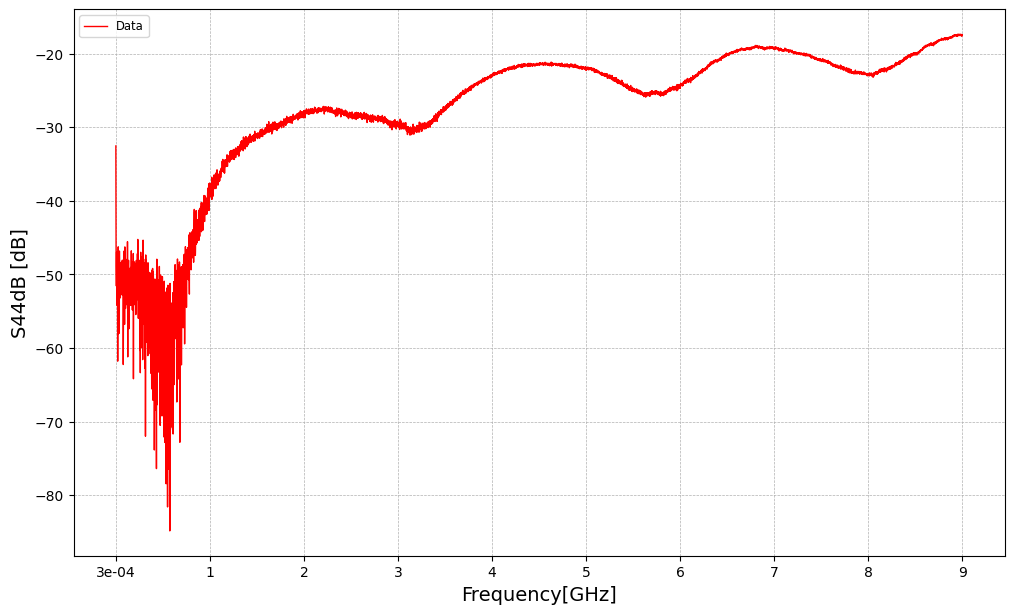

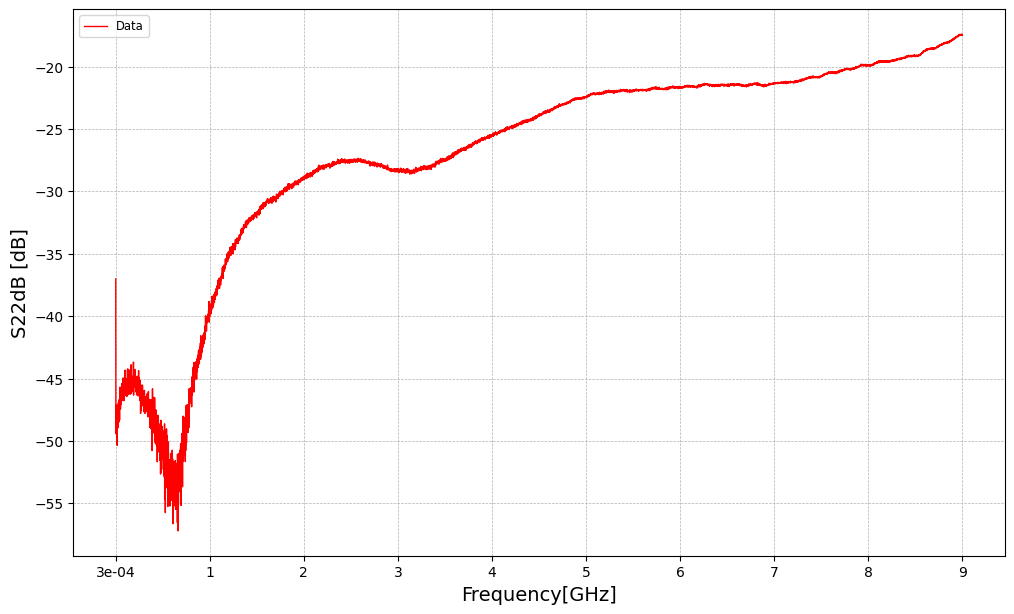

[3.00000000e-04 1.70620313e-03 3.11240625e-03 ... 3.59596139e+00
 3.59736759e+00 3.59877380e+00]
[-2.05944817 -1.02035169 -0.45437004 ...  0.22185219  0.22214877
  0.22164044]
[5.67087997e-21 2.08431945e-10]
[1.05169308e-21 2.18546298e-12]
['(5.7 ± 1.1 × 10^(0)) × 10^-21', '(2.084 ± 2.2 × 10^(-2)) × 10^-10']


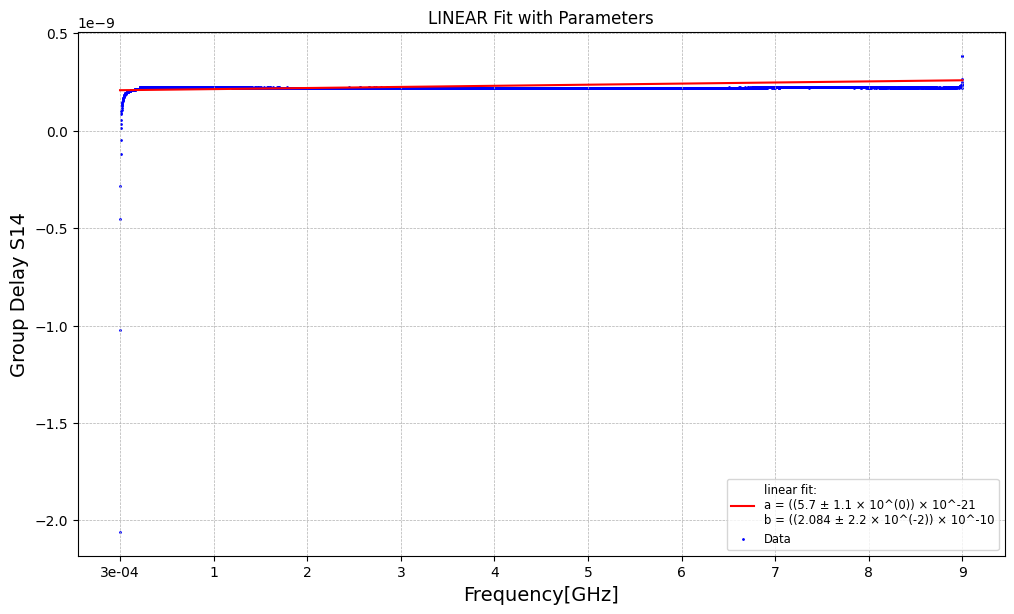

[3.00000000e-04 1.70620313e-03 3.11240625e-03 ... 3.59596139e+00
 3.59736759e+00 3.59877380e+00]
[1.20505433 0.171942   0.08664294 ... 0.00201021 0.00201067 0.00201485]
[-1.3907196e-19  5.4070045e-10]
[4.58366489e-20 9.52505072e-11]
['(-1.39 ± 4.6 × 10^(-1)) × 10^-19', '(5.41 ± 9.5 × 10^(-1)) × 10^-10']


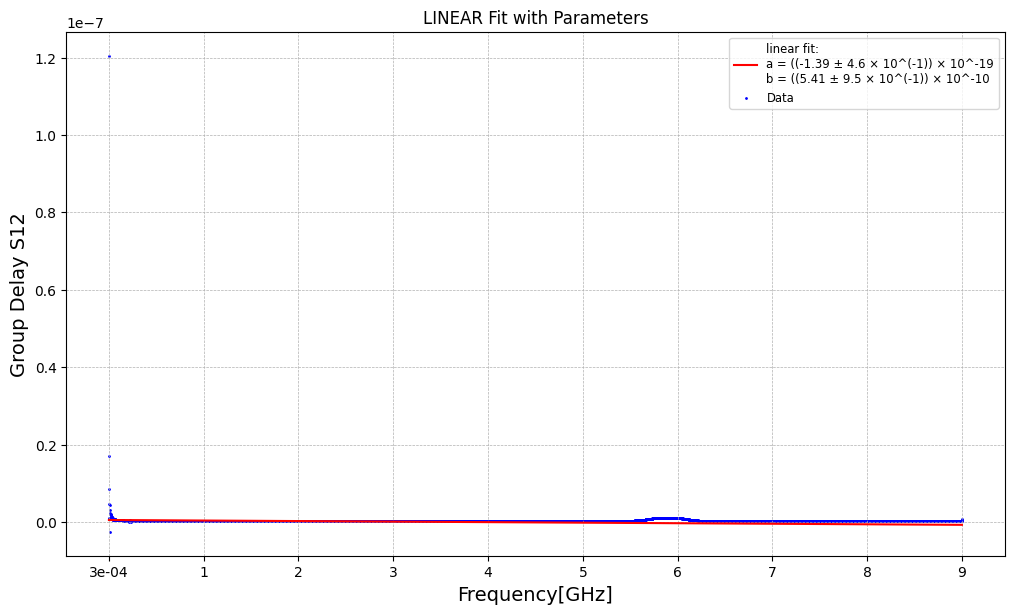

[3.00000000e-04 1.70620313e-03 3.11240625e-03 ... 3.59596139e+00
 3.59736759e+00 3.59877380e+00]
[ 0.43029915  0.87319679  0.70245064 ... -1.79287231 -1.79472031
 -1.79810287]
[-7.4205884e-08  8.7416376e+01]
[3.52217503e-11 7.31922963e-02]
['(-7.4206 ± 3.5 × 10^(-3)) × 10^-8', '(8.7416 ± 7.3 × 10^(-3)) × 10^1']


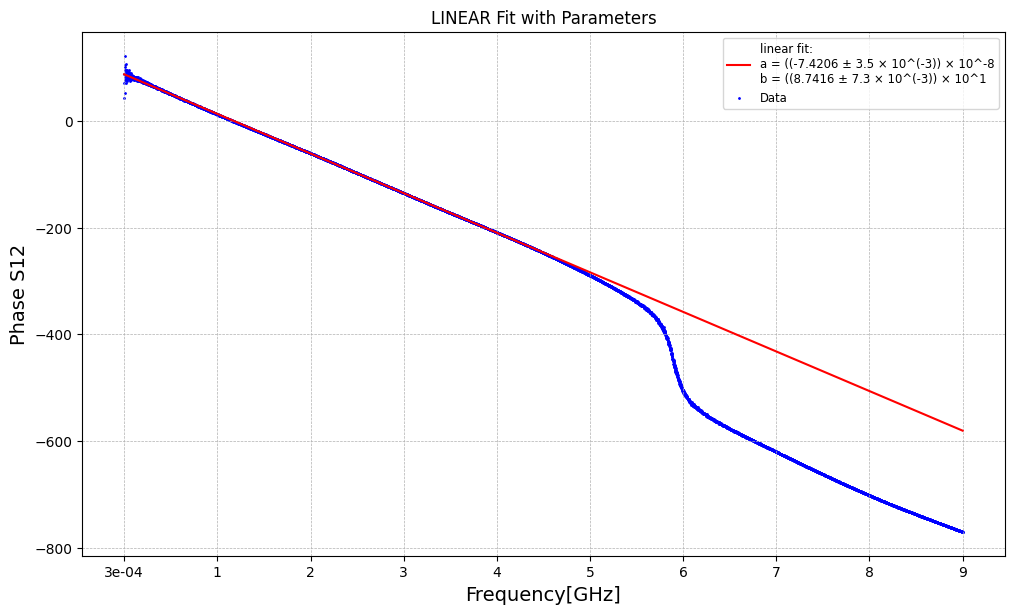

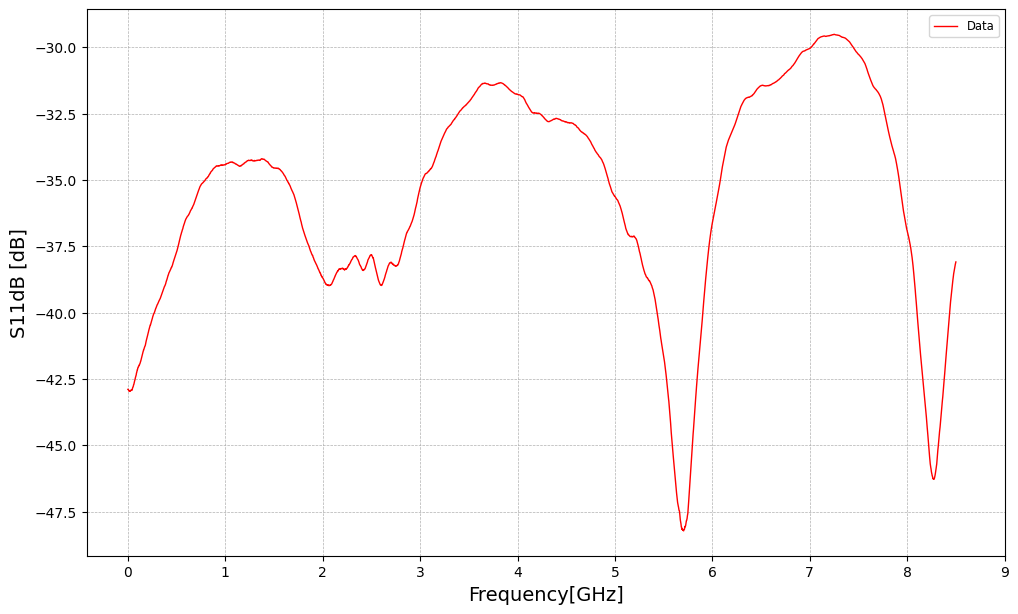

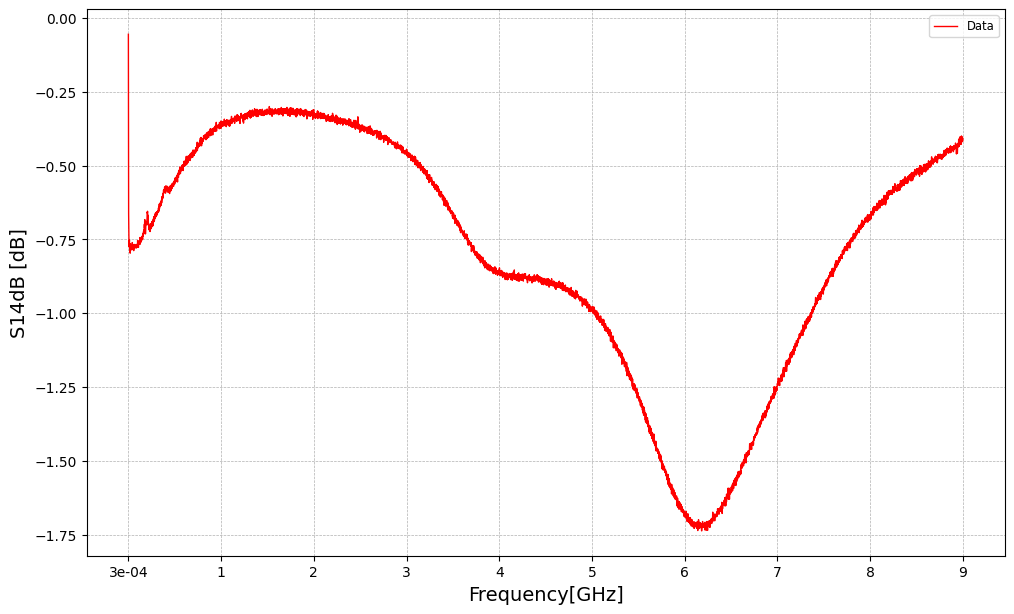

[3.00000000e-04 1.70620313e-03 3.11240625e-03 ... 3.59596139e+00
 3.59736759e+00 3.59877380e+00]
[-0.02546119 -0.02736122 -0.02096676 ... -2.86742737 -2.8689209
 -2.87013306]
[-8.02615779e-08  1.77142572e+00]
[7.76234093e-12 1.61304747e-02]
['(-8.02616 ± 7.8 × 10^(-4)) × 10^-8', '(1.771 ± 1.6 × 10^(-2)) × 10^0']


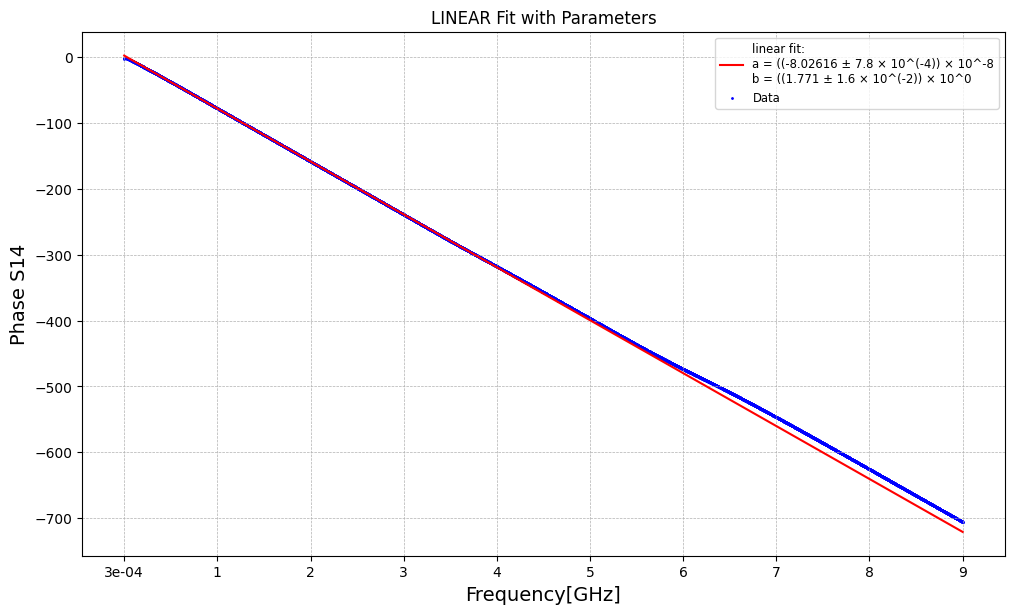

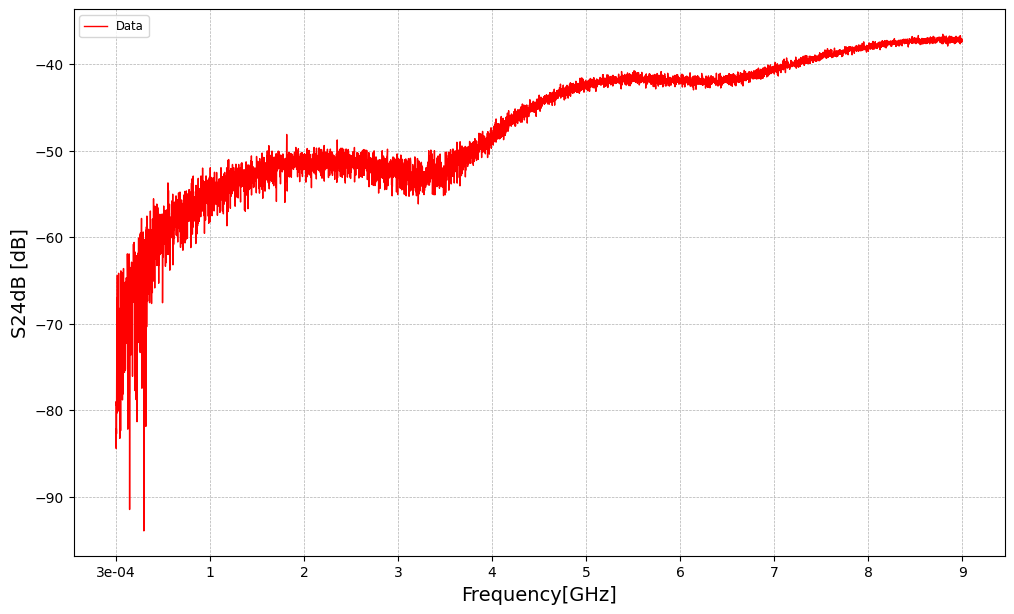

[3.00000000e-04 1.70620313e-03 3.11240625e-03 ... 3.59596139e+00
 3.59736759e+00 3.59877380e+00]
[-3.53299555 -1.33052779  0.16681225 ...  0.01036674  0.00576043
 -0.02686245]
[-1.90914154e-18  4.81056159e-09]
[2.75150277e-19 5.71773985e-10]
['(-1.91 ± 2.8 × 10^(-1)) × 10^-18', '(4.81 ± 5.7 × 10^(-1)) × 10^-9']


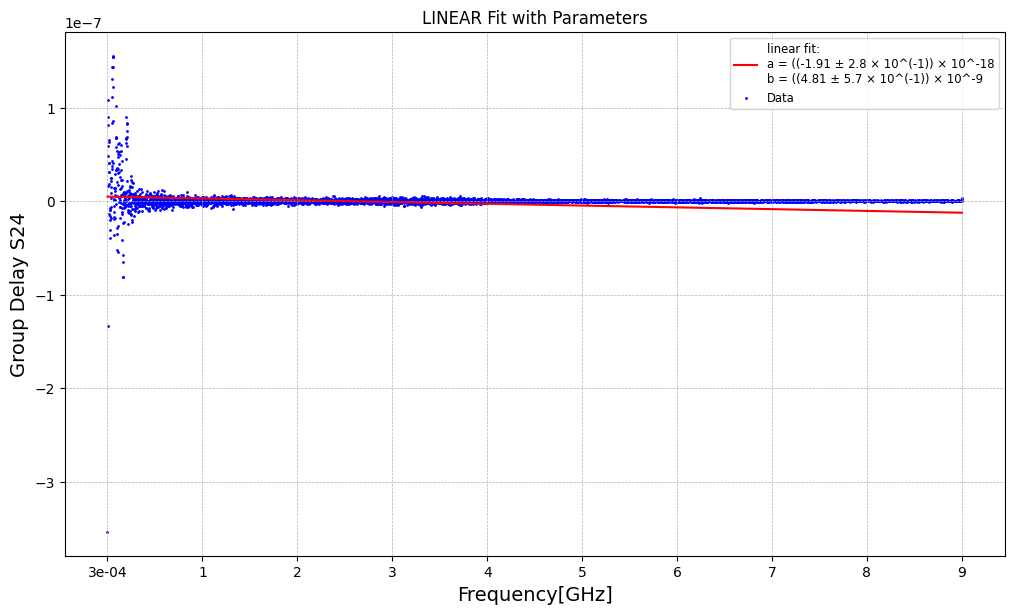

[3.00000000e-04 1.70620313e-03 3.11240625e-03 ... 3.59596139e+00
 3.59736759e+00 3.59877380e+00]
[-1.63043671 -0.41829529  0.37308144 ... -1.78186569 -1.78138016
 -1.77805817]
[-7.39234443e-08  8.82921563e+01]
[1.11928257e-10 2.32591680e-01]
['(-7.392 ± 1.1 × 10^(-2)) × 10^-8', '(8.829 ± 2.3 × 10^(-2)) × 10^1']


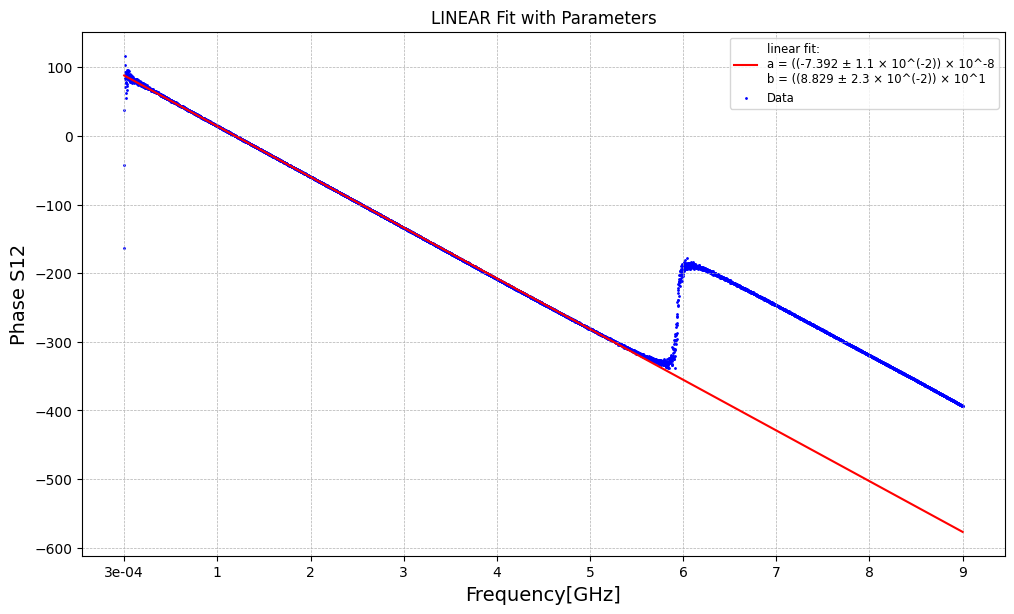

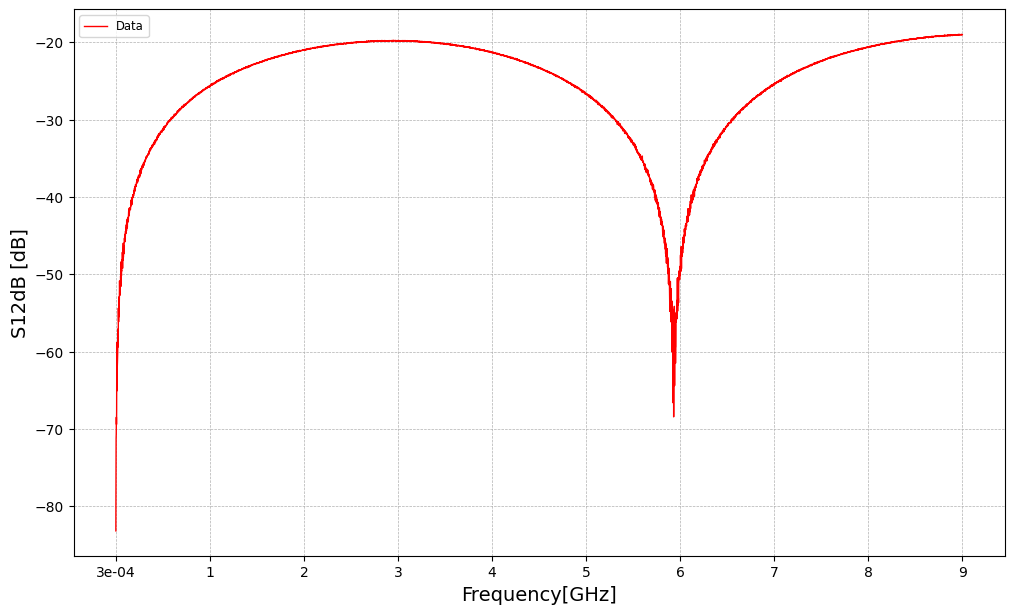

In [ ]:
folder = "/content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab03/DirectionalCoupler"
filenames, configs, results = generate_and_plot_figs(folder)





In [ ]:
print(results["S12_dB"]()[1])

[-76.21838379 -73.0244751  -75.69639587 ... -19.87542152 -19.82348633
 -19.77363968]


In [ ]:
import numpy as np

def compute_directivity(results):

    S13 = results["S12_dB"]
    S12 = results["S24_dB"]

    assert (S13.x_data == S12.x_data).all(), "Frequency data does not match for S31 and S21"

    directivity_dB = (S13.y_data - S12.y_data)

    plot_data(x_data = S13.x_data,
              y_datas = directivity_dB,
              x_label = "Frequency [GHz]",
              y_label = "Directivity [dB]",
              y_labels = "Directivity [dB]",
              fit=False,
              square_root=False,
              save=True,
              filename="Directivity_dB"
              )



def compute_isolation(results):

    S12 = results["S24_dB"]

    isolation_dB = S12.y_data


    plot_data(x_data= S12.x_data,
              y_datas= isolation_dB,
              x_label = "Frequency [GHz]",
              y_label = "Isolation [dB]",
              y_labels = "Isolation [dB]",
              fit=False,
              square_root=False,
              save=True,
              filename="Isolation_dB"
              )




def compute_coupling(results):

    S24 = results["S12_dB"]

    Coupling_dB =  S24.y_data


    plot_data(x_data = S24.x_data,
              y_datas = Coupling_dB,
              x_label = "Frequency [GHz]",
              y_labels = "Coupling[dB]",
              y_label = "Coupling[dB]",
              fit=False,
              square_root=False,
              save=True,
              filename="Coupling_dB"
              )




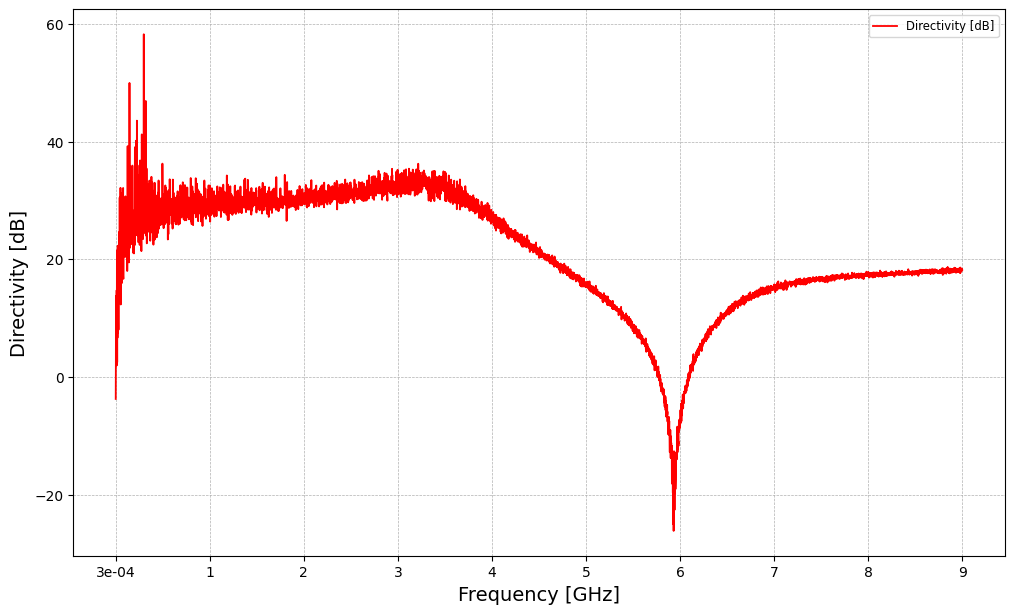

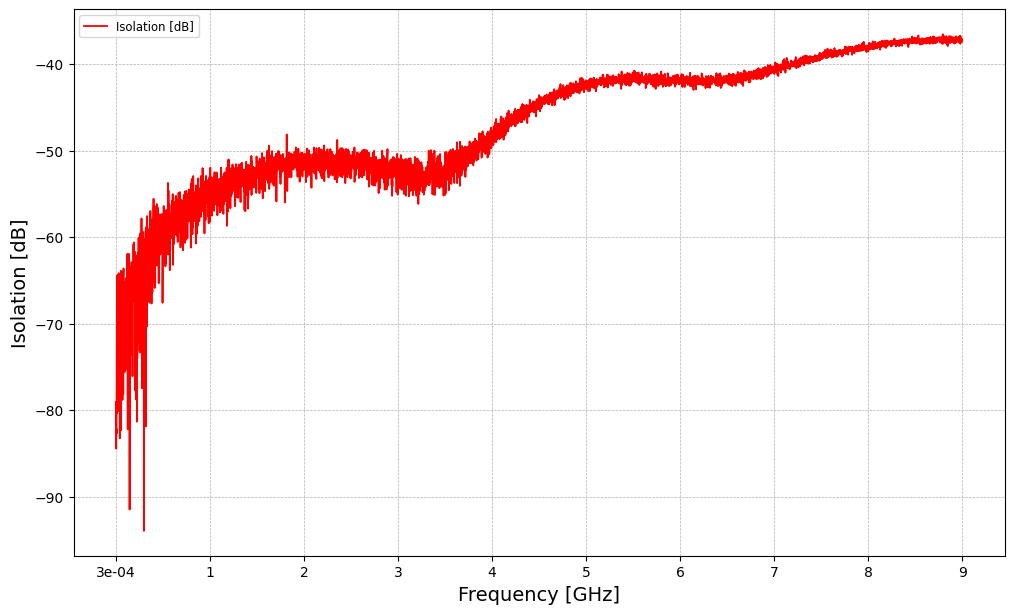

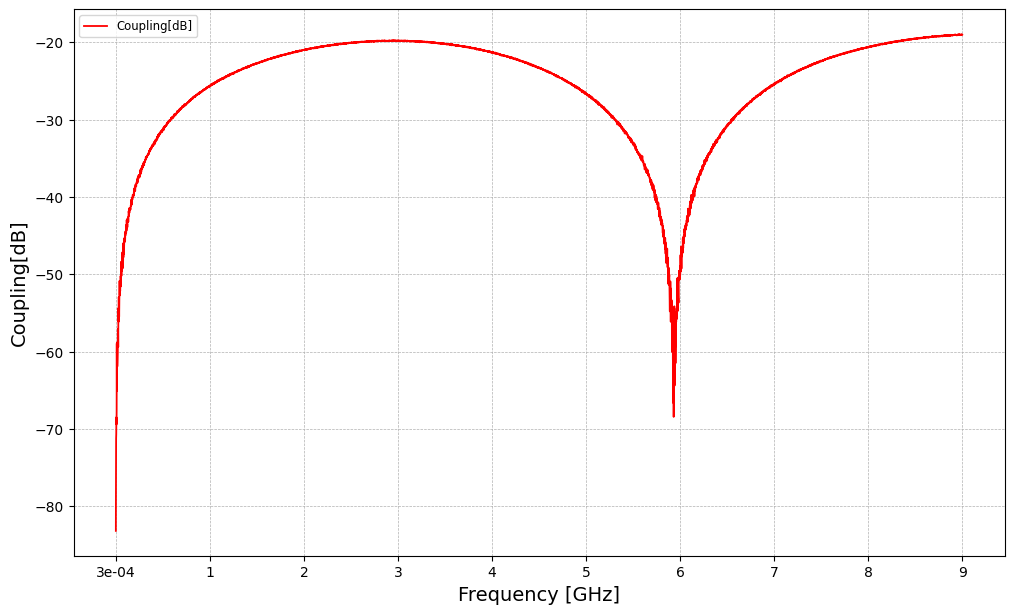

In [ ]:
compute_directivity(results)
compute_isolation(results)
compute_coupling(results)


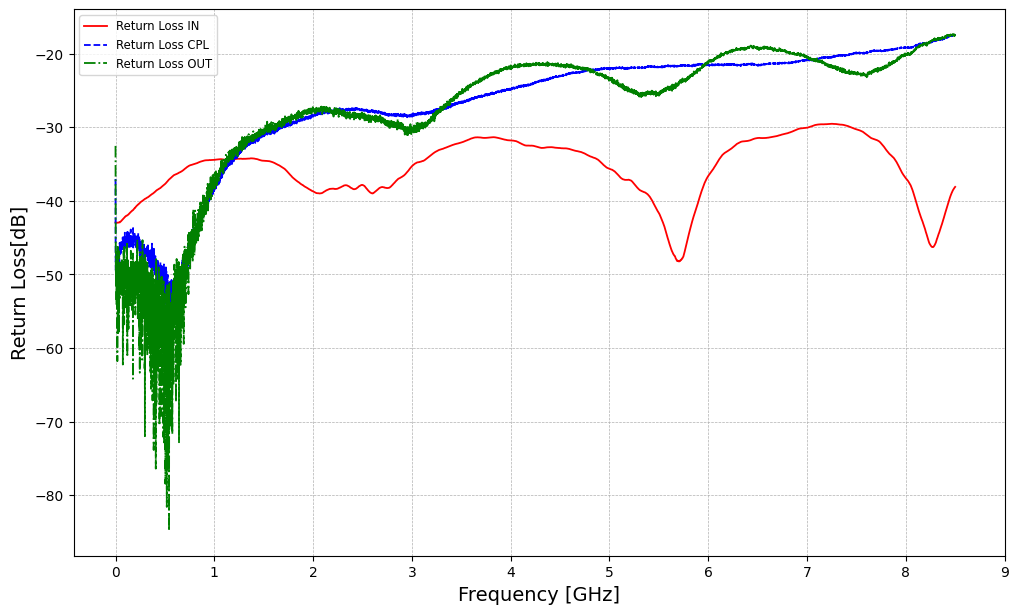

In [ ]:
x_data = results["S11_dB"]()[0]
y_datas = [results[f"S{11*i}_dB"]()[1] for i in[1,2,4]]
y_labels = ["Return Loss IN","Return Loss CPL","Return Loss OUT"]


plot_data(x_data = x_data,
              y_datas = y_datas,
              x_label = "Frequency [GHz]",
              y_labels = y_labels,
              y_label = "Return Loss[dB]",
              fit=False,
              square_root=False,
              save=True,
              filename="ReturnLoss_dB"
              )


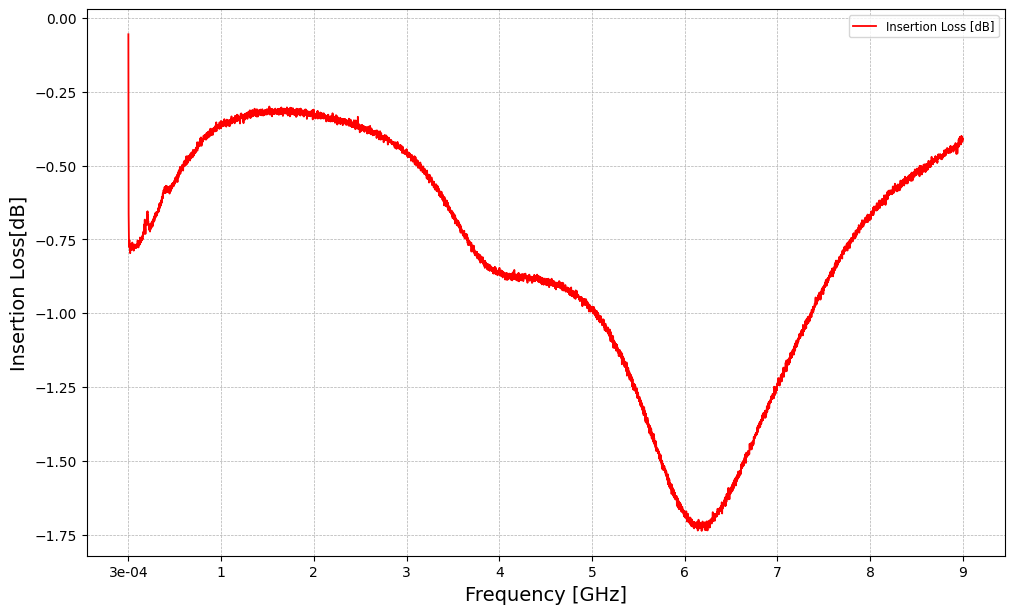

In [ ]:
plot_data(x_data = results["S14_dB"]()[0],
              y_datas = results["S14_dB"]()[1],
              x_label = "Frequency [GHz]",
              y_labels = "Insertion Loss [dB]",
              y_label = "Insertion Loss[dB]",
              fit=False,
              square_root=False,
              save=True,
              filename="InsertionLoss_dB"
              )


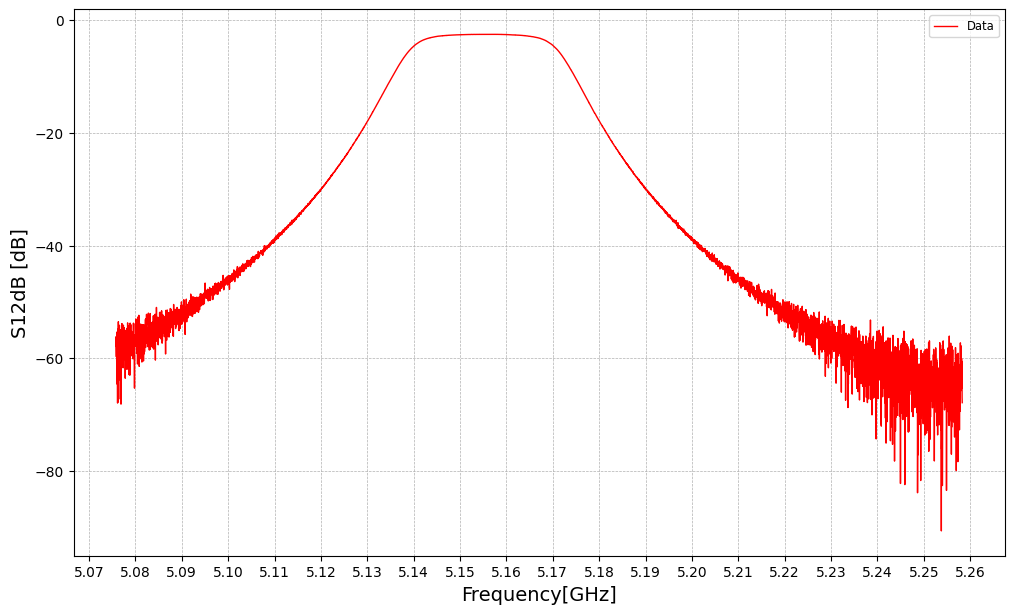

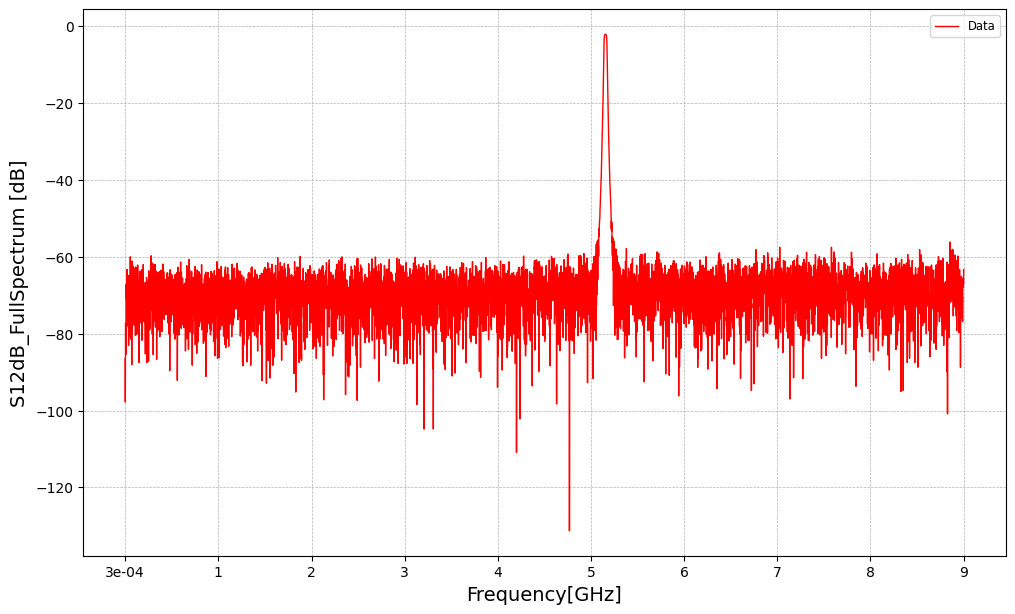

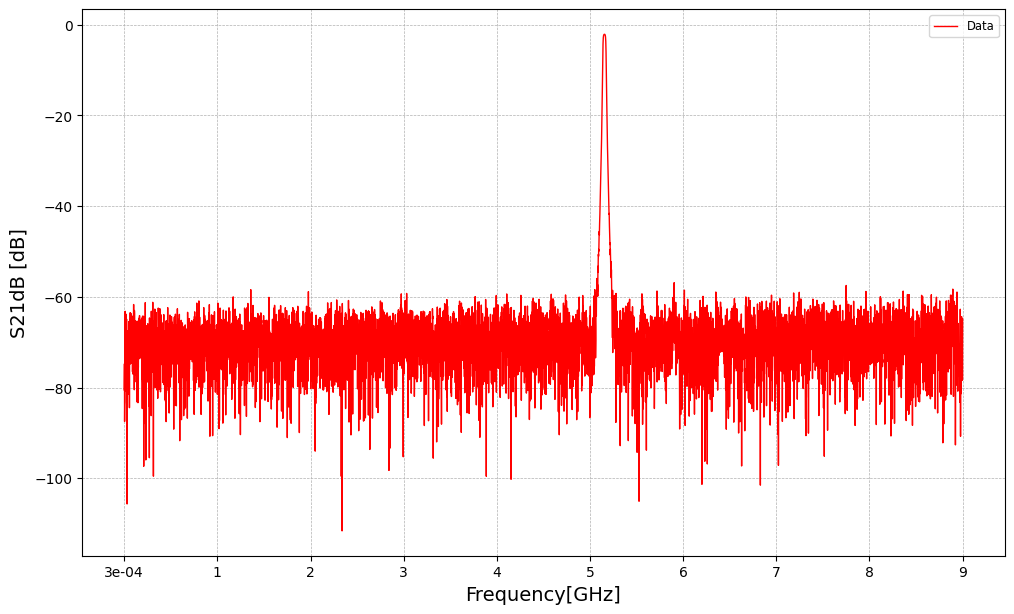

[5.138984   5.13898904 5.13899407 ... 5.15186329 5.15186833 5.15187336]
[ 1.27953018  1.27799232  1.27796257 ... -0.23129938 -0.2314805
 -0.231924  ]
[-1.16317868e-05  5.98972808e+04]
[1.43152789e-08 7.36582654e+01]
['(-1.1632 ± 1.4 × 10^(-3)) × 10^-5', '(5.9897 ± 7.4 × 10^(-3)) × 10^4']


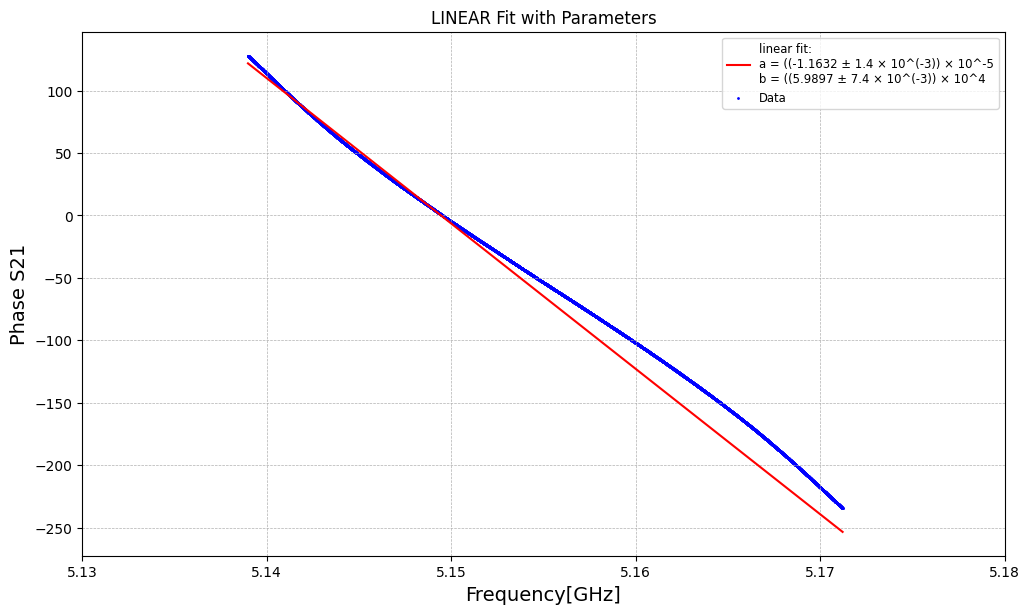

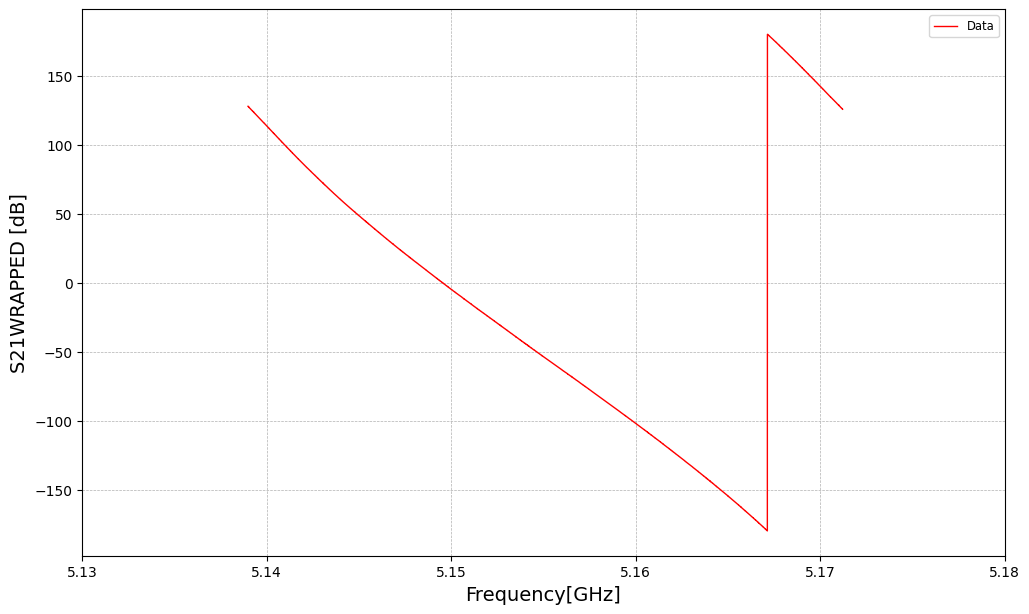

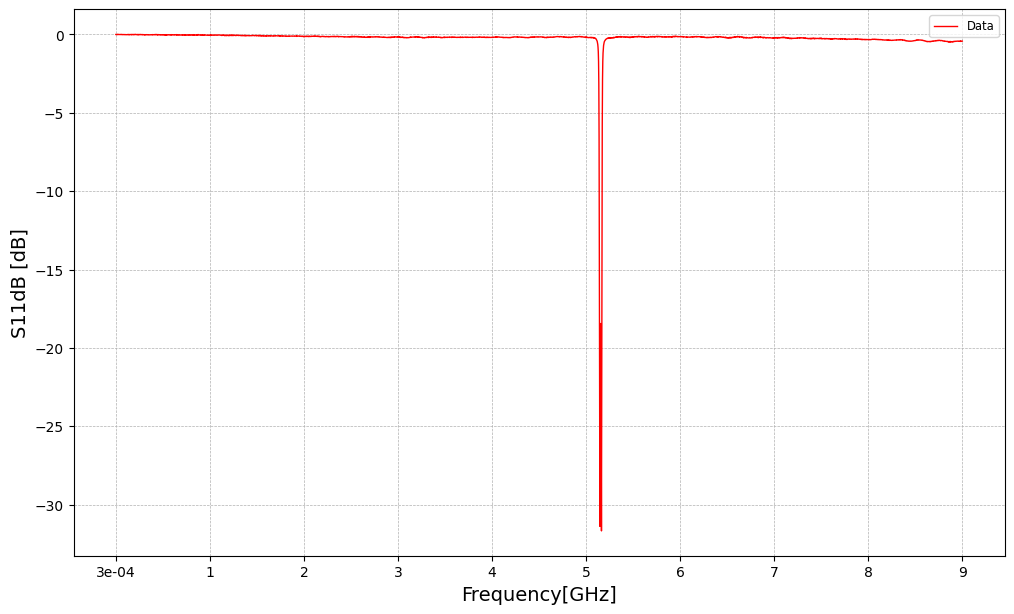

In [ ]:
folder = "/content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab03/Filter"
filenames, configs, results = generate_and_plot_figs(folder)


{'S12_dB': <__main__.mat_to_py object at 0x7b6a74151f50>, 'S21_dB': <__main__.mat_to_py object at 0x7b6a73d1b450>, 'S21_phase': <__main__.mat_to_py object at 0x7b6a73e59e50>, 'S11_dB': <__main__.mat_to_py object at 0x7b6a73c36710>}
[5.155102   5.15510704 5.15511207 ... 5.16153409 5.16153913 5.16154416]
[-0.54594803 -0.54597782 -0.54621288 ... -1.1739978  -1.17424232
 -1.17445183]
[-9.74483936e-06  5.01814022e+04]
[2.63887781e-09 1.36121853e+01]
['(-9.7448 ± 2.6 × 10^(-3)) × 10^-6', '(5.0181 ± 1.4 × 10^(-3)) × 10^4']


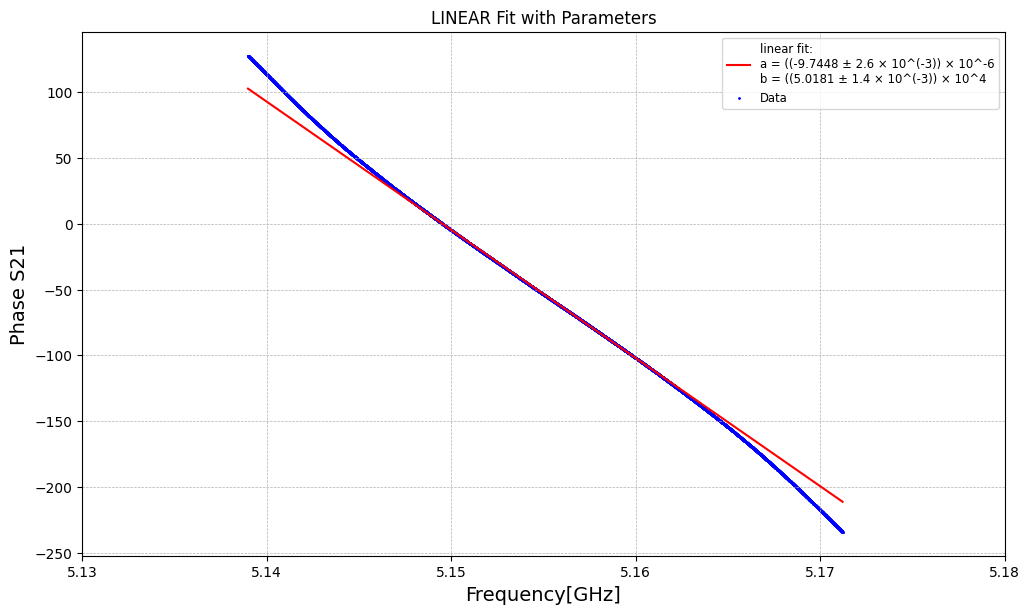

In [ ]:
print(results)
phase = results['S21_phase']
phase.plot(fit = True, save = True,  starting_point = 0.5, fitlength= 0.1 )

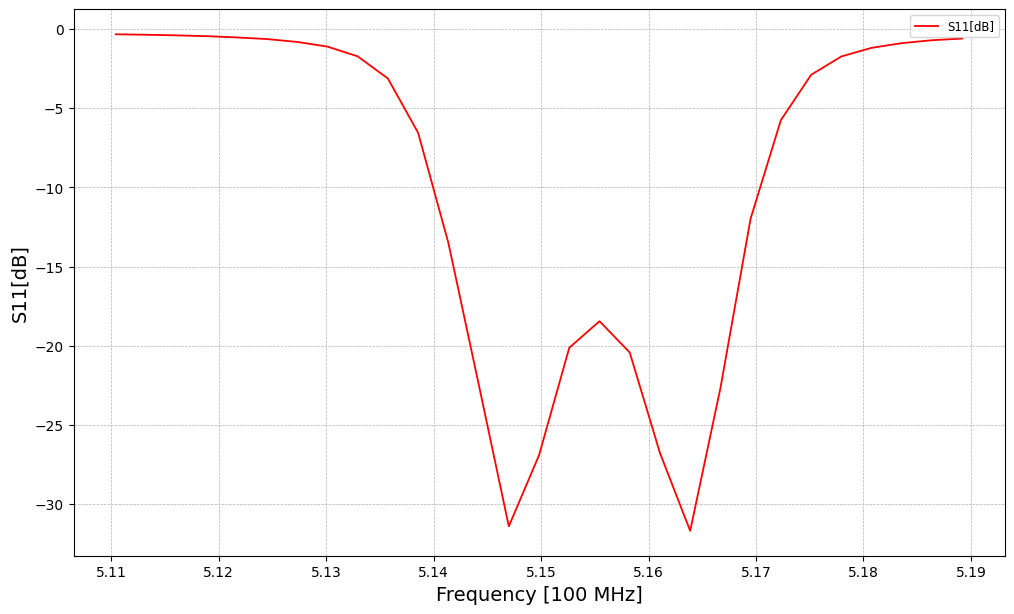

In [ ]:
xdata = results["S11_dB"]()[0]
ydata = results["S11_dB"]()[1]

good_range = (xdata > 5.11e+9 ) & (xdata < 5.19e+9)
xdata = xdata[good_range]
ydata = ydata[good_range]

plot_data(x_data = xdata,
              y_datas = ydata,
              x_label = "Frequency [100 MHz]",
              y_labels = "S11[dB]",
              y_label = "S11[dB]",
              fit=False,
              square_root=False,
              save=True,
              filename="S11_peak_dB"
              )

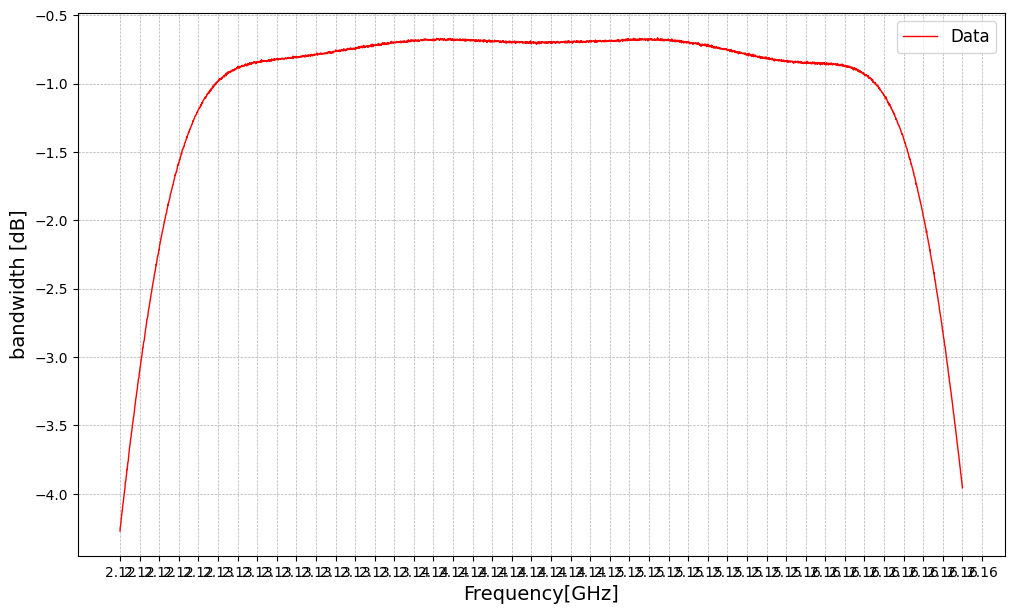

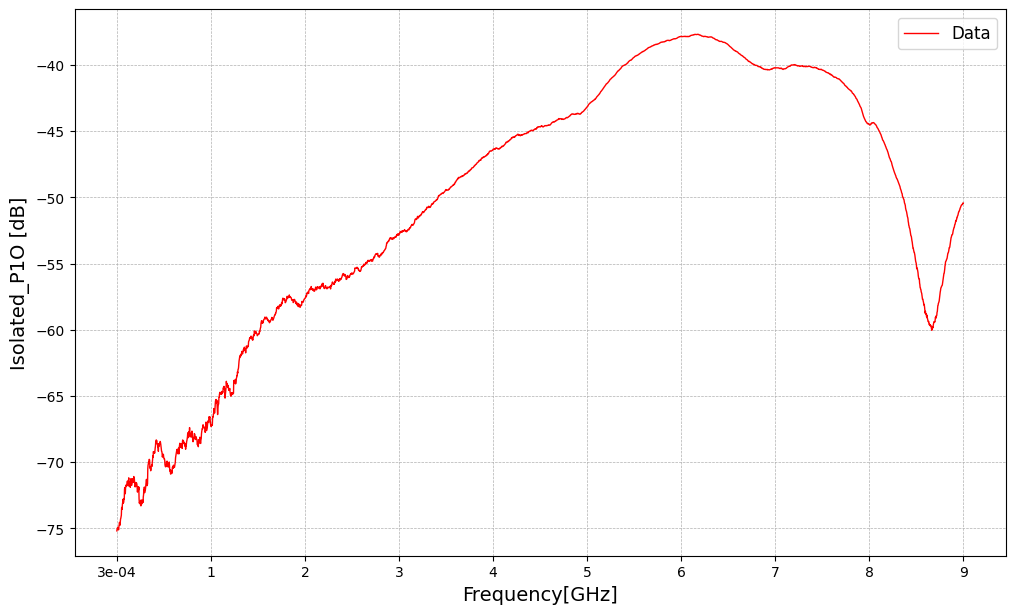

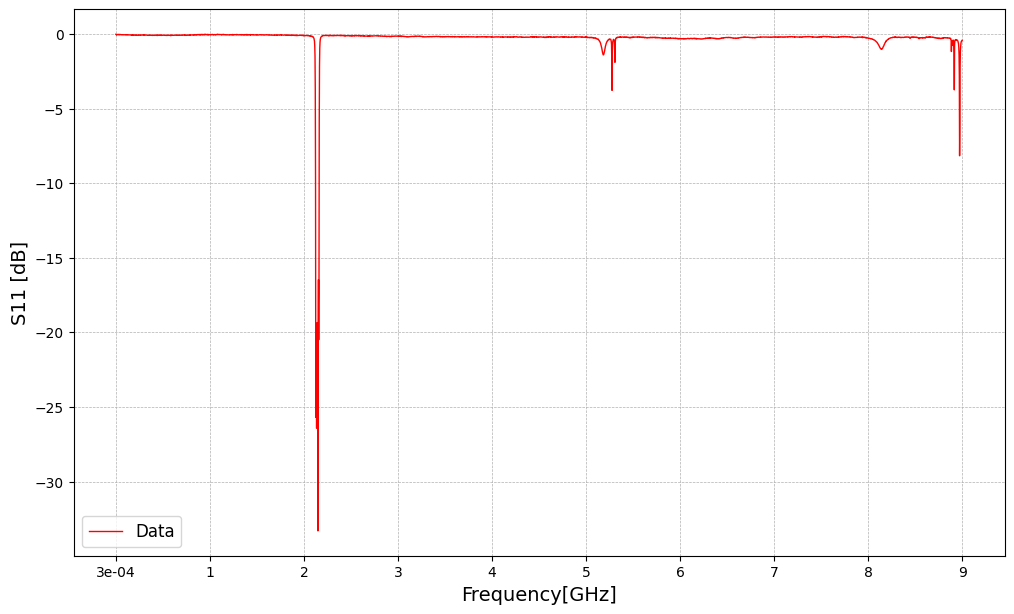

['(-1.0340 ± 2.8 × 10^(-3)) × 10^4', '(2.1966 ± 5.9 × 10^(-3)) × 10^4']


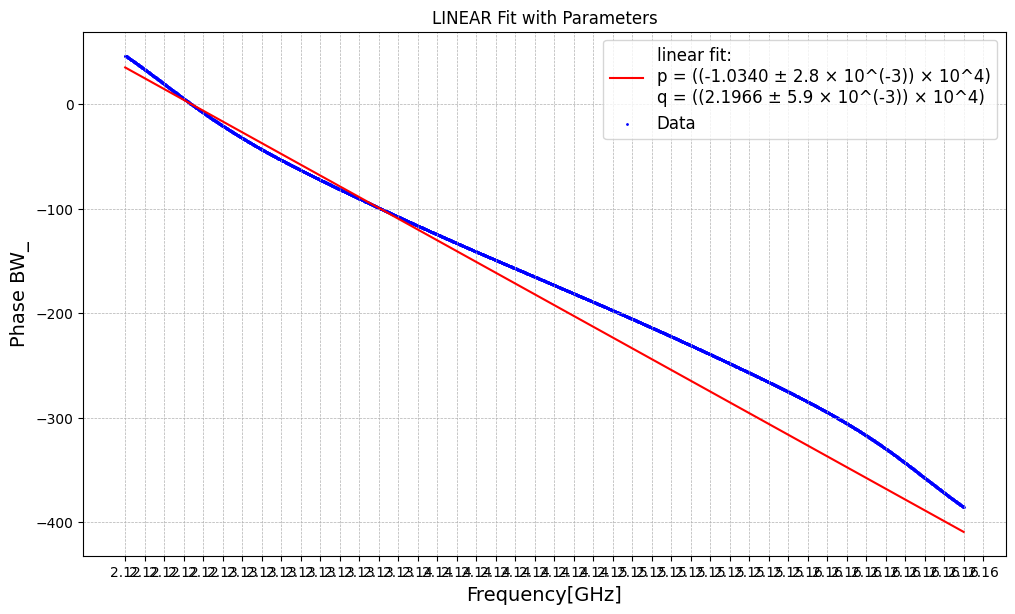

In [ ]:
folder = "/content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/shazail/DAY3 Data/Passband filter"
filenames, configs, results = generate_and_plot_figs(folder)

[2.1425     2.14251344 2.14252688 2.14254031 2.14255375 2.14256719
 2.14258062 2.14259406 2.1426075  2.14262094 2.14263438 2.14264781
 2.14266125 2.14267469 2.14268812 2.14270156 2.142715   2.14272844
 2.14274188 2.14275531 2.14276875 2.14278219 2.14279563 2.14280906
 2.1428225  2.14283594 2.14284937 2.14286281 2.14287625 2.14288969
 2.14290313 2.14291656 2.14293    2.14294344 2.14295687 2.14297031
 2.14298375 2.14299719 2.14301063 2.14302406 2.1430375  2.14305094
 2.14306437 2.14307781 2.14309125 2.14310469 2.14311812 2.14313156
 2.143145   2.14315844 2.14317188 2.14318531 2.14319875 2.14321219
 2.14322562 2.14323906 2.1432525  2.14326594 2.14327938 2.14329281
 2.14330625 2.14331969 2.14333312 2.14334656 2.14336    2.14337344
 2.14338688 2.14340031 2.14341375 2.14342719 2.14344063 2.14345406
 2.1434675  2.14348094 2.14349437 2.14350781 2.14352125 2.14353469
 2.14354813 2.14356156 2.143575   2.14358844 2.14360187 2.14361531
 2.14362875 2.14364219 2.14365563 2.14366906 2.1436825  2.1436

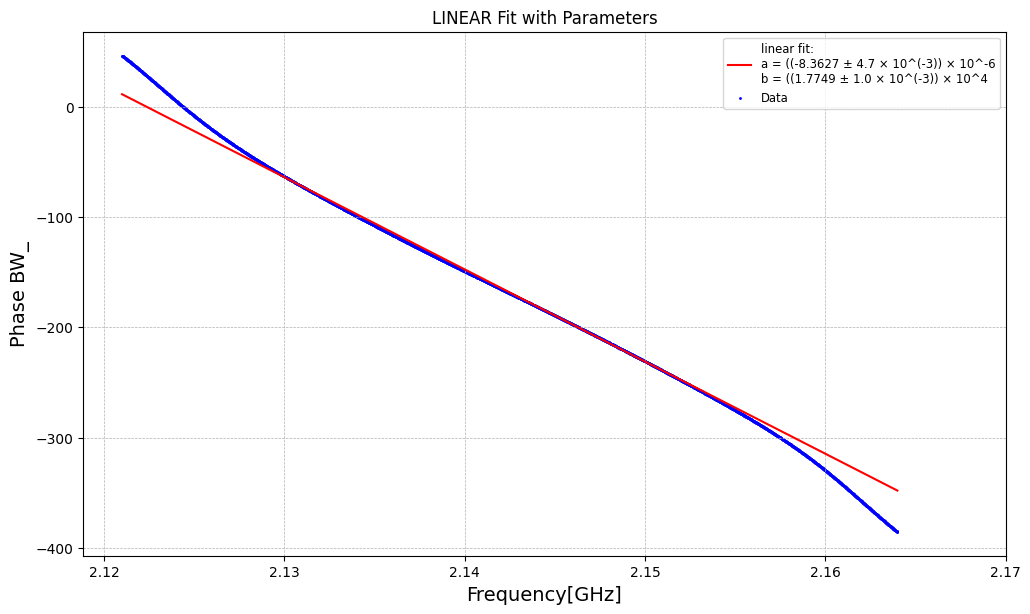

In [ ]:
BW_phase = results["BW__phase"]
BW_phase.plot(fit = True, fitlength=0.25, save = True, starting_point = 0.5)

In [ ]:
a = np.array([-8.36268627e-06,  4.73247286e-09])
b = a/360
print(b)
c = 3e10 #cm/s
print(b*c)
scientific_notation(6.96408409e+02,3.94099909e-01 )
scientific_notation(2.32296841e-08,  1.31457579e-11)

[-2.32296841e-08  1.31457579e-11]
[-6.96890523e+02  3.94372738e-01]


'(2.3230 ± 1.3 × 10^(-3)) × 10^-8'

In [ ]:
S21dB_filename = "/content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab04/TM010_S21.fig"
S21dB = mat_to_py(S21dB_filename, labels = ["Frequency[GHz]", "S21 [dB]"])
frequencies = S21dB.x_data
S21dB_exp= S21dB.y_data
f0 = frequencies[S21dB_exp.argmax()]
S21_f0 = S21dB_exp.max()
S21dB_norm = S21dB_exp-S21_f0


In [ ]:
def S21_dB_func(f,f0,QL):
  delta = (f/f0) - (f0/f)
  S21 = np.abs( (1+(QL*delta)*1j))
  return -20*np.log10(S21)



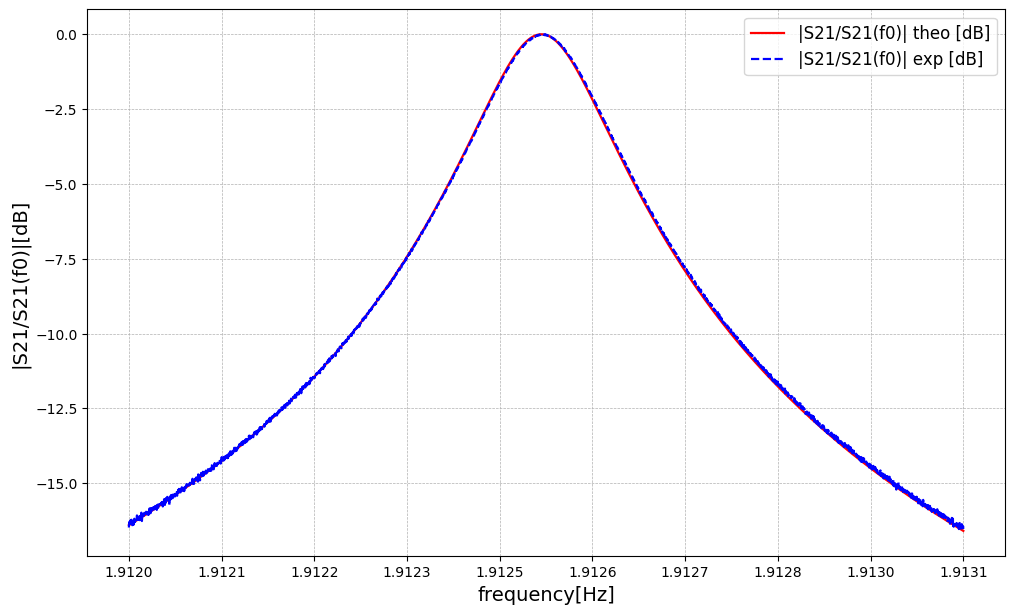

In [ ]:
S21dB_theo = S21_dB_func(frequencies,f0,11537)
plot_data(x_data = frequencies,
          y_datas = [S21dB_theo, S21dB_norm],
          x_label = "frequency[Hz]",
          y_labels = ["|S21/S21(f0)| theo [dB]", "|S21/S21(f0)| exp [dB]"],
          y_label = "|S21/S21(f0)|[dB]",
          subdivisions = 0.0001,
          fit=False,
          starting_point=0.5,
          fitlength=0.2,
          square_root=False,
          save=False,
          filename="plot"
          )


Found 7 peaks.
Peak found at: 1912691269.13
Peak found at: 3048604860.49
Peak found at: 3988898889.89
Peak found at: 4387938793.88
Peak found at: 4630363036.3
Peak found at: 5459645964.6
Peak found at: 5612061206.12


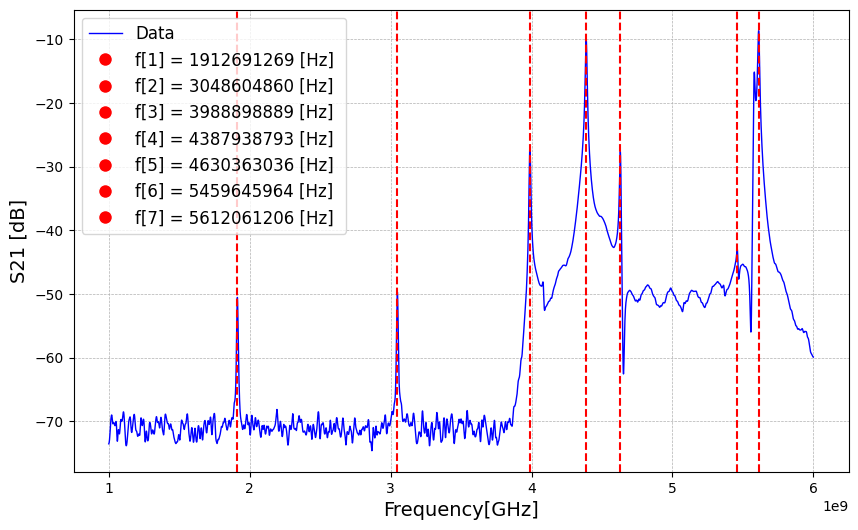

array([1521, 3414, 4981, 5646, 6050, 7432, 7686])

In [ ]:
fullRange_filename = "/content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab04/FullRange_S21.fig"
FullRangeS21dB = mat_to_py(fullRange_filename, labels = ["Frequency[GHz]", "S21 [dB]"])
FullRangeS21dB.peak_behaviour(num_peaks = 10,
                              xrange= [3e+6,6e+9],
                              sigma_filter=7,
                              save = False,
                              prominence = 6,
                              threshold = 0.001
                              )



Found 2 peaks.
Peak found at: 5579057905.79
Peak found at: 5612061206.12


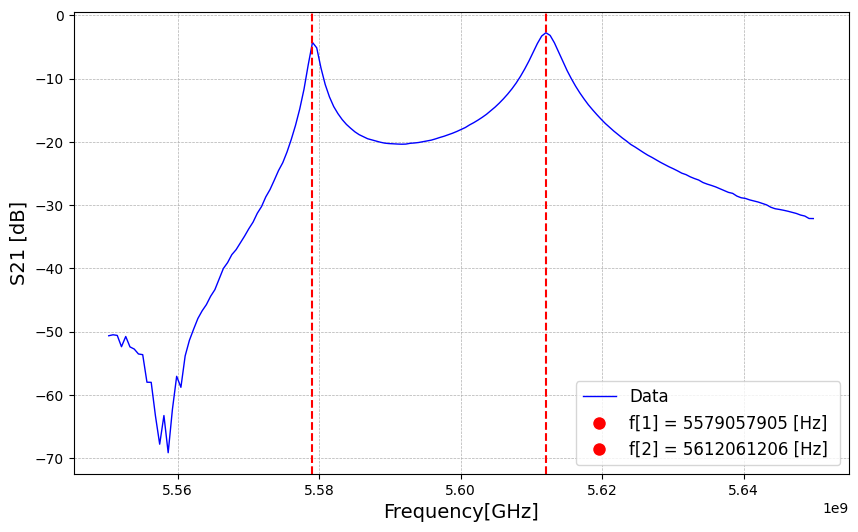

array([ 48, 103])

In [ ]:
FullRangeS21dB.peak_behaviour(num_peaks = 10,
                              xrange= [5.55e+9,5.65e+9],
                              sigma_filter=1e-8,
                              save = False,
                              prominence =5,
                              threshold = 1e-10
                              )

In [29]:
%cd /content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab04
!ls

/content/drive/.shortcut-targets-by-id/1AuQag8Q8nLh3HEHq5FZHSemd0TKrzs7s/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab04
Datastruct.mat	      TE211_Peak.png	   TM110_peak.png
Datastruct_TE211.mat  TE211_S21_PEAK.fig   TM110_S21_PEAK.fig
Datastruct_TM020.mat  TM010_Peak.png	   TM120_Peak.png
Datastruct_TM110.mat  TM010_PHASE.fig	   TM120_S21_PEAK.fig
Datastruct_TM120.mat  TM010_PHASE_fit.fig  TM211_Peak.png
Datastruct_TM211.mat  TM010_S21_PEAK.fig   TM211_S21_PEAK.fig
FullRange_S21.fig     TM020_Peak.png
Smith		      TM020_S21_PEAK.fig


Phase TM010_PHASE
Phase TM010_PHASE_fit
Full Range FullRange_S21
Peak TE211_S21_PEAK
Peak TM010_S21_PEAK
Peak TM020_S21_PEAK
Peak TM110_S21_PEAK
Peak TM120_S21_PEAK
Peak TM211_S21_PEAK
['(-6.965 ± 8.6 × 10^(-2)) × 10^5', '(1.332 ± 1.6 × 10^(-2)) × 10^6']


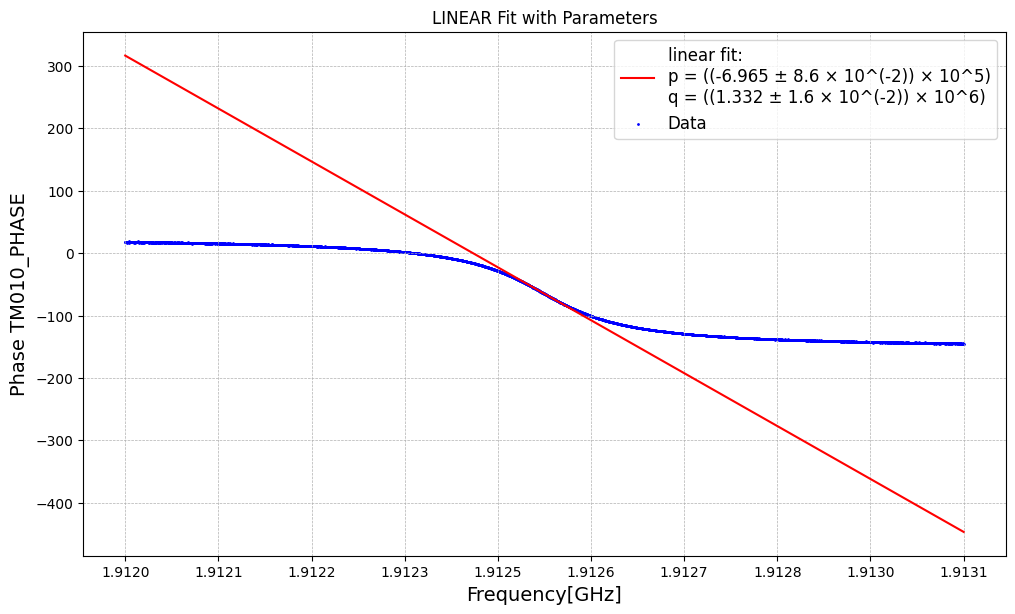

['(-1.216 ± 1.5 × 10^(-2)) × 10^4', '(2.325 ± 2.9 × 10^(-2)) × 10^4']


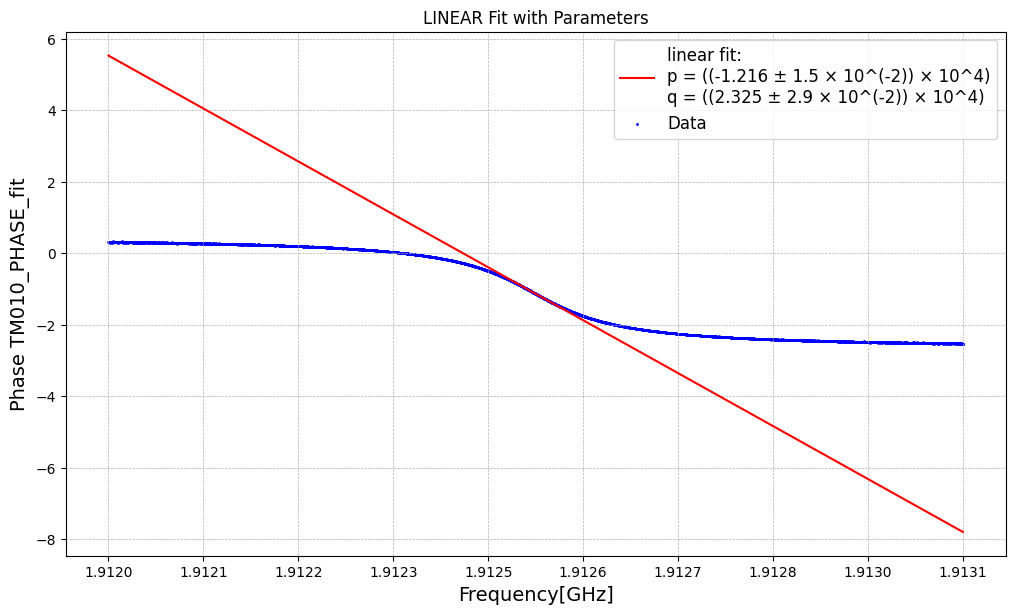

Found 7 peaks.
Peak found at: 1912691269.13
Peak found at: 3048604860.49
Peak found at: 3988898889.89
Peak found at: 4387938793.88
Peak found at: 4630363036.3
Peak found at: 5459645964.6
Peak found at: 5612061206.12


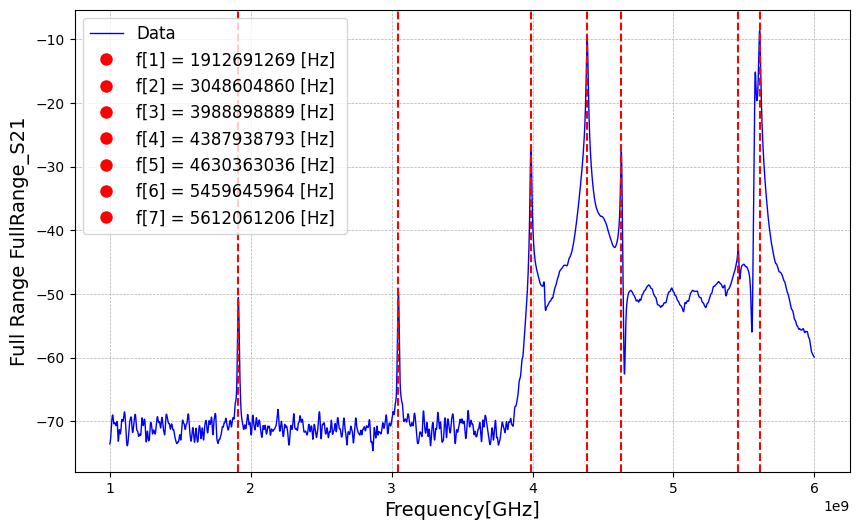

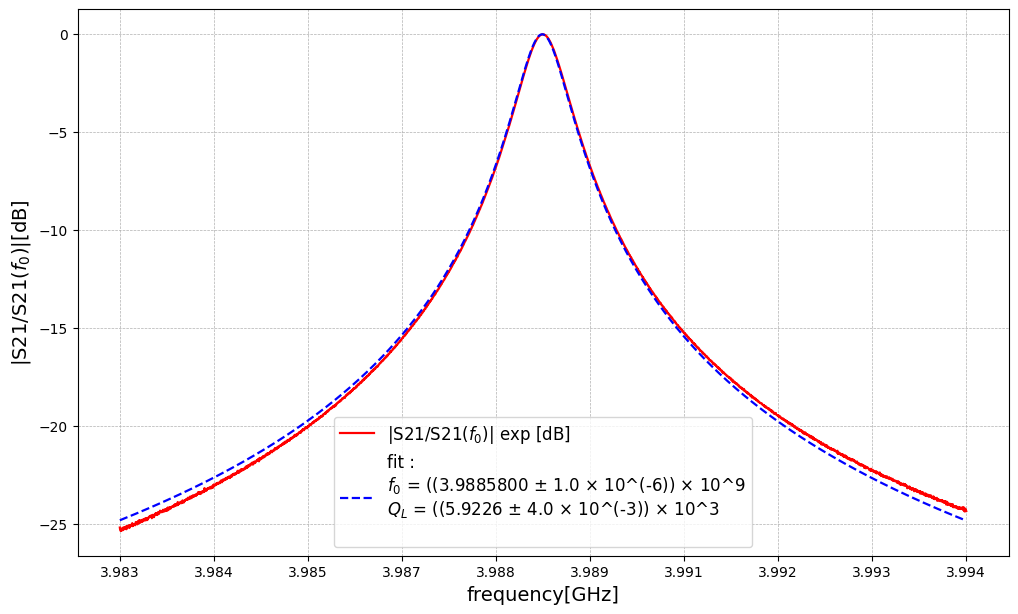

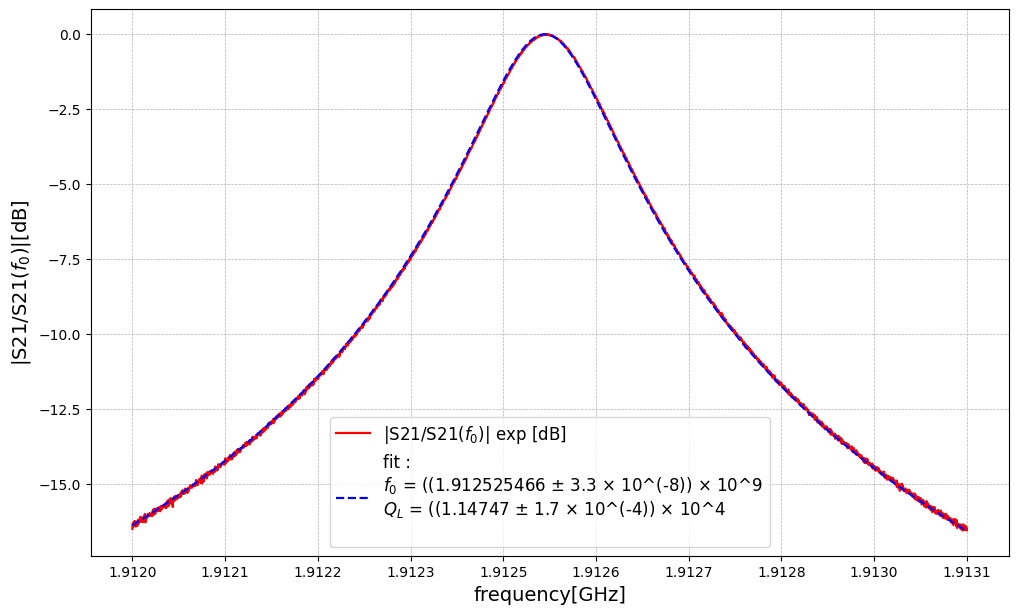

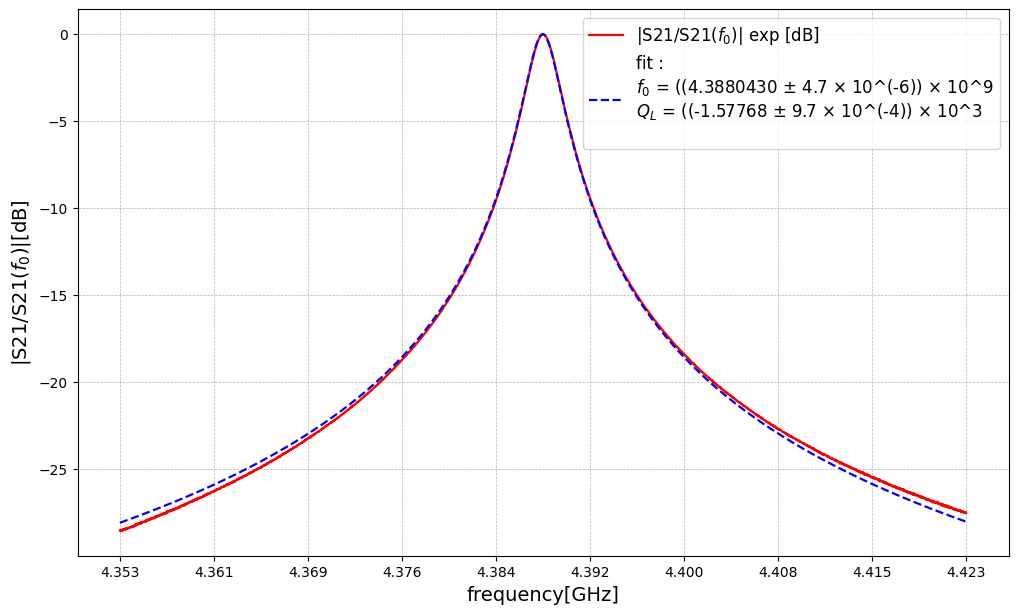

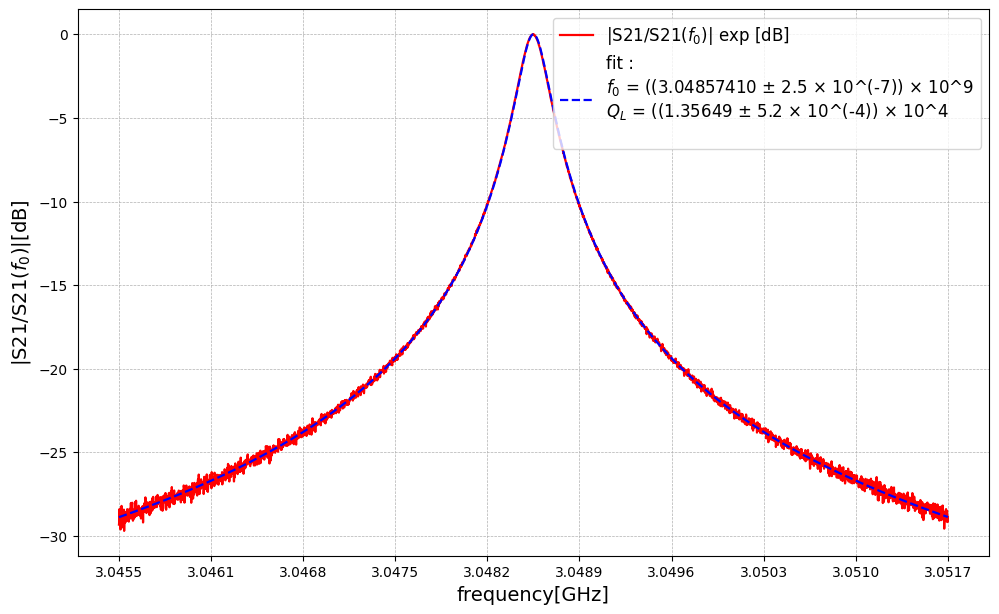

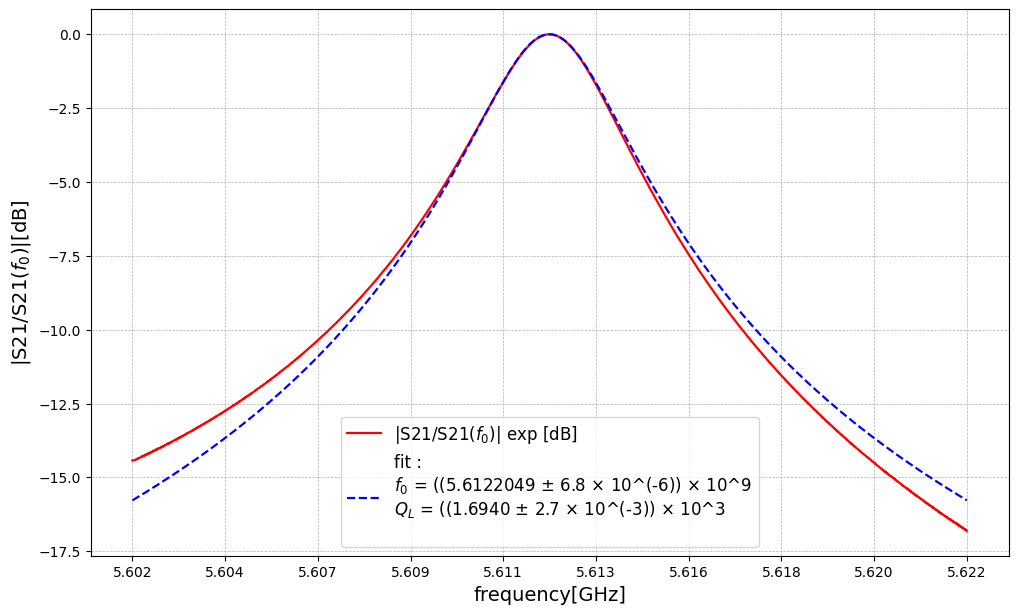

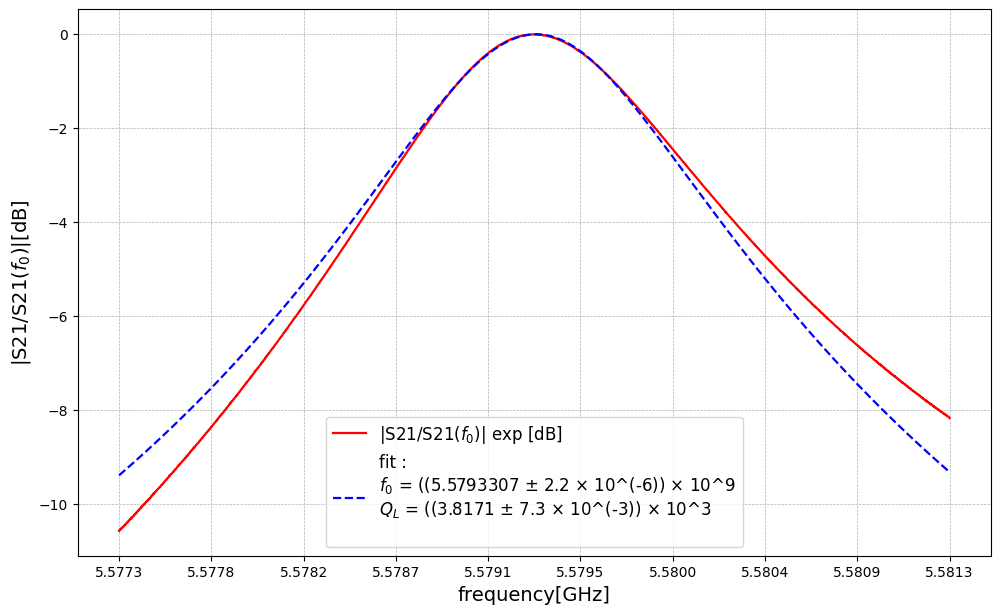

In [26]:
folder_lab04 = "/content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/Santiago/Lab04"
filenames, configs, results = generate_and_plot_figs(folder_lab04,
                                                     savefile= False,
                                                     fit_starting_point= 0.5,
                                                     fit_length=0.005,
                                                     range = [3e6,6e9])

In [27]:
print(results)


{'TM010_PHASE_phase': <__main__.mat_to_py object at 0x7d5883f64ad0>, 'TM010_PHASE_FIT_phase': <__main__.mat_to_py object at 0x7d5883f45e10>, 'FULLRANGE_S21_fullrange': <__main__.mat_to_py object at 0x7d588b257390>, 'TE211_S21_PEAK_peak': <__main__.mat_to_py object at 0x7d58840cb950>, 'TM010_S21_PEAK_peak': <__main__.mat_to_py object at 0x7d5883f86b90>, 'TM020_S21_PEAK_peak': <__main__.mat_to_py object at 0x7d588458c310>, 'TM110_S21_PEAK_peak': <__main__.mat_to_py object at 0x7d58844fe210>, 'TM120_S21_PEAK_peak': <__main__.mat_to_py object at 0x7d5883f34ed0>, 'TM211_S21_PEAK_peak': <__main__.mat_to_py object at 0x7d588b735f10>}


In [15]:
%cd /content/drive/MyDrive/2025_NaCav2_experiment/StudentWorkSpaces/shazail/DAY4\ Data
!ls

/content/drive/.shortcut-targets-by-id/1AuQag8Q8nLh3HEHq5FZHSemd0TKrzs7s/2025_NaCav2_experiment/StudentWorkSpaces/shazail/DAY4 Data
CodeImagesS12.jpg	    S12Phase_NoCalibration_ZoomFit.fig
CodeS12.fig		    S12Phase_NoCalibration_ZoomNoFit.fig
Plot_S12_Ampl_Phase.asv     S21_1to3dB_NoCalibration.fig
Plot_S12_Ampl_Phase.m	    S21_SmallWindow_NoCalibration.fig
S12Phase_NoCalibration.fig
